In [27]:
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import glob
import numpy as np
import os, glob
import csv
import operator

def prunDataFrame(dataframe):
    dataframe = dataframe.drop('geo', 1)
    dataframe = dataframe.drop('mx', 1)
    dataframe = dataframe.drop('mn', 1)
   # dataframe = dataframe.drop('wc', 1)


    dataframe = dataframe[['latency','start_ts','wc']].apply(pd.to_numeric,errors='coerce')
    dataframe = dataframe.sort_values(by='start_ts', ascending=[True])

   # dataframe = dataframe.drop('window', 1)
    return dataframe

def buildDataFrame(filePath):
    df_temp = pd.read_csv(filePath,names=['geo','latency','mx','mn','wc','start_ts'])
    df_temp = prunDataFrame(df_temp)
    return df_temp


def pruneForDenseWindows(dataframe,percentage):
    pd.to_numeric(dataframe.wc)
    topWindows = dataframe.wc.quantile(percentage)
    #print(topWindows)
    dataframe = dataframe[dataframe.wc > topWindows  ]
    return dataframe


def pandasDraw(listOfFilePaths,_figsize,_range,_quantile=None):
    for fileGroup in listOfFilePaths:
        df_list = []
        for file in fileGroup:
            column_name = file.rsplit('.', 1)[0]
            temp_df = buildDataFrame(file)
            if not (_quantile is None):
                temp_df = pruneForDenseWindows(temp_df,_quantile)
            temp_df_with_cols = pd.DataFrame({column_name:temp_df.latency},
                    columns=[column_name])
            df_list.append(temp_df_with_cols)
        df_final = pd.concat(df_list)
        ax_df_final = df_final.hist(figsize=_figsize,bins=100,range=_range)
    plt.show()
    


def dataGeneratorStats(path,_figsize):
    d = {}
    fileCount = 0
    for filePath in glob.glob(path + '*'):
        fileCount = fileCount + 1
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) , 1
            k = int(k)
            if k in d:
                d[k]  = tuple(map(operator.add, d[k], v))
            else:
                d[k] = v
    finalD = {}
    for k, v in d.items():
        if v[1] == fileCount:
            finalD[k] = v[0]
    df = pd.DataFrame(list(finalD.items()),columns=['ts', 'count'])
    df = df.sort_values(by='ts', ascending=[True])
    df.plot.bar(y='count', x = 'ts',figsize=_figsize,)
    plt.show()

def dataGeneratorStatsSeparate(path,_figsize,_xlabel,_ylabel,_xticks):
    df_list = []
    for filePath in glob.glob(path + '*'):
        d = {}
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) 
            k = int(k)
            d[k] = v
        #print( [int(i[1]) for i in d.items()] )
        df = pd.DataFrame({'ts':[int(i[0]) for i in d.items()] , 'count': [int(i[1]) for i in d.items()]},columns=['ts', 'count'])
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl
        df_list.append(df)
        ax=df.plot(y='count', x = 'ts',figsize=_figsize, xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks) ,marker='x')
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)

    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    plt.show()

def dataGeneratorStatsSeparateOneAxis(path,_figsize,_xlabel,_ylabel,_xticks):
    for filePath in glob.glob(path + '*'):
        d = {}
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) 
            k = int(k)
            d[k] = v
        #print( [int(i[1]) for i in d.items()] )
        df = pd.DataFrame({'ts':[int(i[0]) for i in d.items()] },columns=['ts'])
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl
        df['count'] = list(range(1, len(df) + 1))


        ax = df.plot.line( x = 'ts',
                          y='count',
                          figsize=_figsize, 
                          marker='x',
                          xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks))
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)
        
    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    
    plt.show()

    



# Introduction

Stream Data Processing Systems (SDPS) is designed to do transformations and query continuous data streams. It is similar to a database management system (DBMS), which is, however, designed for static data in conventional databases.
There are several open source SDPS which are used both by academia and industry. In this work, we picked Apache Storm, Apache Spark and Apache Flink to compare their performances in terms of latency and thoughput. 



# Experiments
In all experiments, we used system structure shown below.

<img src="images/system_design.png">

There are two main components of the system: data generators and system under test (s_t). They are connected though socket.To achieve high data generation rates and to be able to stress testing, we configure the system to be able to accept and process finite number of different stream sources. Each data generator pushes the tuples to its buffer and s_t pulls to get data from buffer. To achieve high efficiency, array based blocking queue data structure is used on buffer where generators are producers and s_t is consumer. 

O_e in figure is the operator that extracts data received from socket and constructs tuples from it. O_t is an operator to be tested and O_f is the one to put final timestamp to tuple and calculate latency for tuple. 

In all experiments, the following statistics are measured:
- Buffer size of each data generator. The size is measured while producer is alive. After producer finishes its task, measurement ends.
- Producer rate of each data generator to buffer.
- Consumer rate of system under test from each buffer. 


## Windowed Aggregations

The experiments is divided to 4 sections, being 4x, 2x and 1x to show the data generation rate. In general nx is a system consisting of n data generators with same speed.

### 4x, Flink


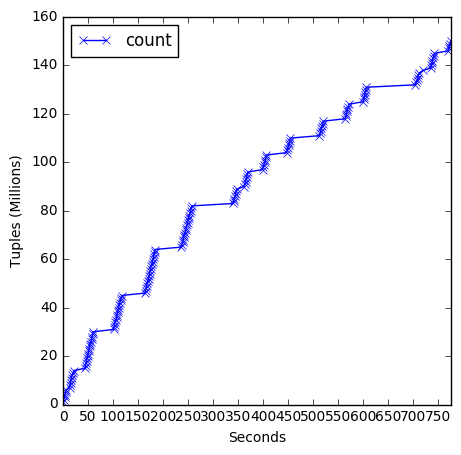

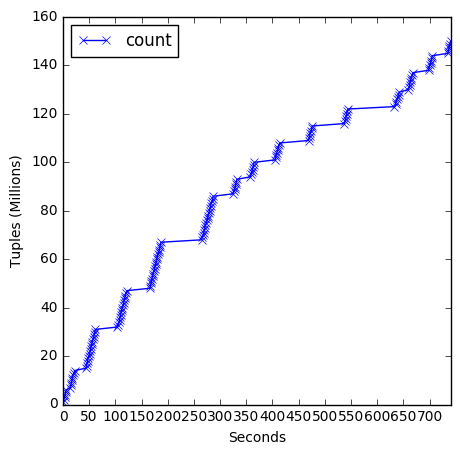

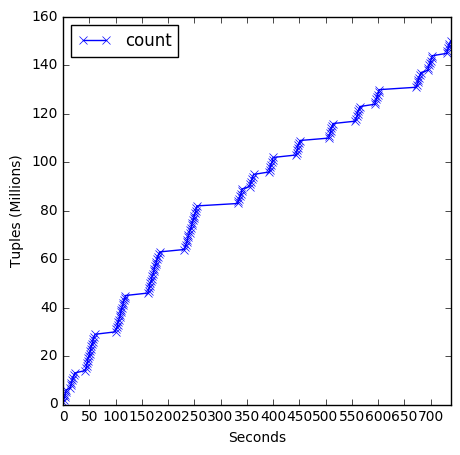

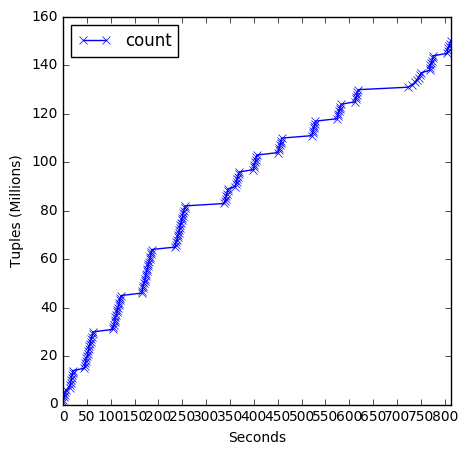

In [84]:
dataGeneratorStatsSeparateOneAxis('/Users/jeka01/Desktop/temp/stats/4x/flink/datarate',(5,5),'Seconds','Tuples (Millions)',50)


The above figures show the producer rate of 4 generators. Generators push data to buffer. x axis shows the time in seconds, where 0 is the time when first tuple is inserted to buffer. The measurement is ended when last tuple is generated.
Each dot in figure shows when 1M tuples are produced. So, the frequent dots in figure the more data is generated. 
There are some intervals that generation speed is slow. The reason for that is stalls of garbrage collector.

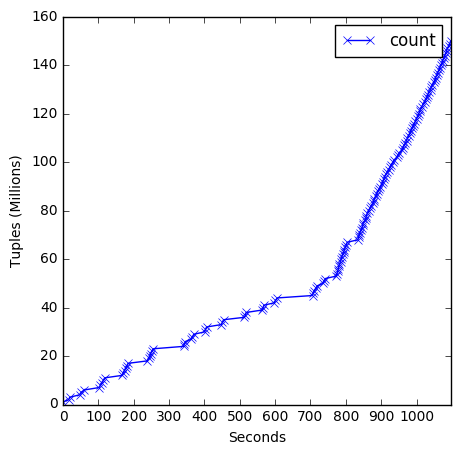

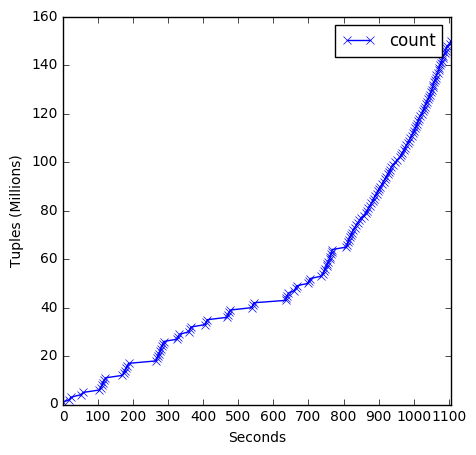

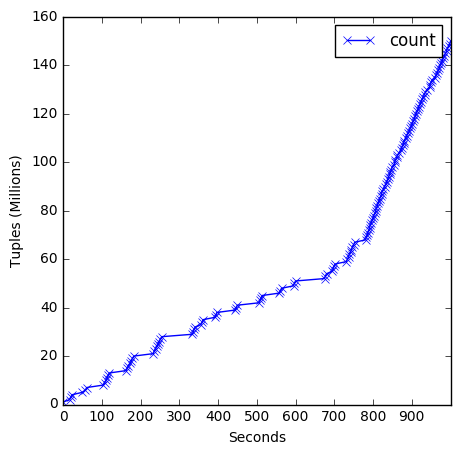

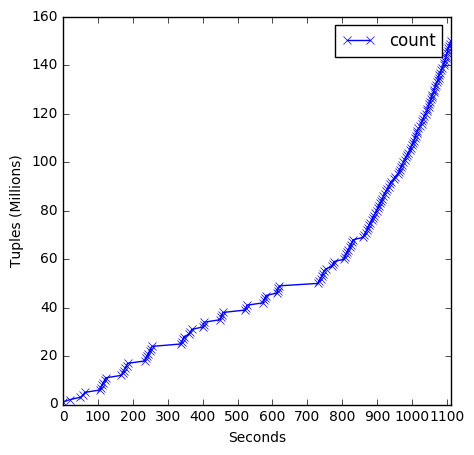

In [75]:
dataGeneratorStatsSeparateOneAxis('/Users/jeka01/Desktop/temp/stats/4x/flink/thoughput',(5,5),'Seconds','Tuples (Millions)',100)

This figure shows the consumer rate from different buffers. The consume rate increases after 810 seconds. That is the time when producer finishes to push data to buffer. Because, these threads are blocking each other, one is blocking another. Therefore, once producer threads are finished, consumer can work more efficiently. 
- We can consider pushing data to buffer first and then fire consumer to read. However, in this case, the data generation rate cannot be contolled and always will be at max. 
- Moreover, especially in latency calculation where millisecond is a matter, changing this structure for another can cause loss of precision. 

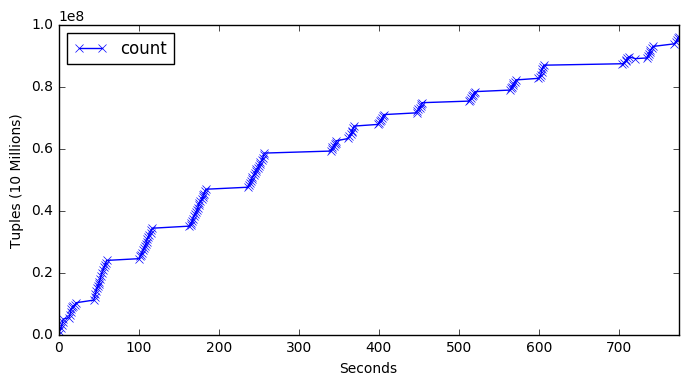

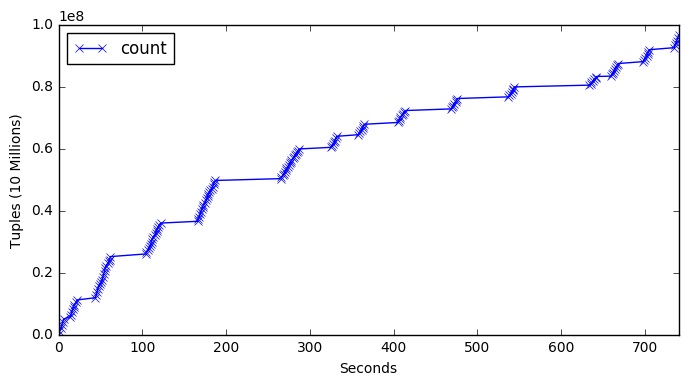

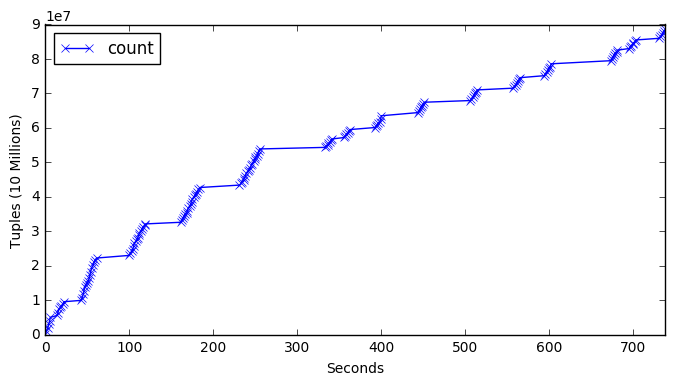

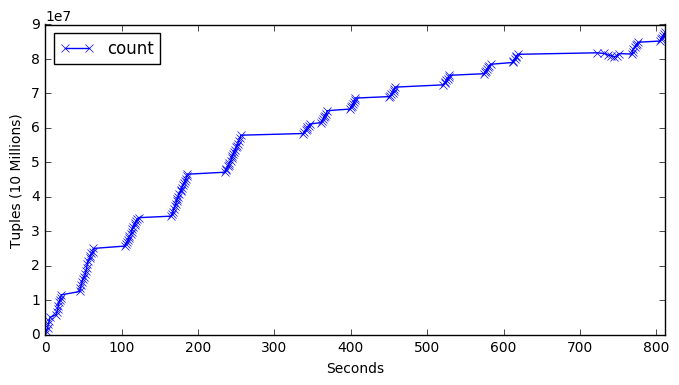

In [2]:

dataGeneratorStatsSeparate('/Users/jeka01/Desktop/temp/stats/4x/flink/buffer',(8,4),'Seconds','Tuples (10 Millions)',100)



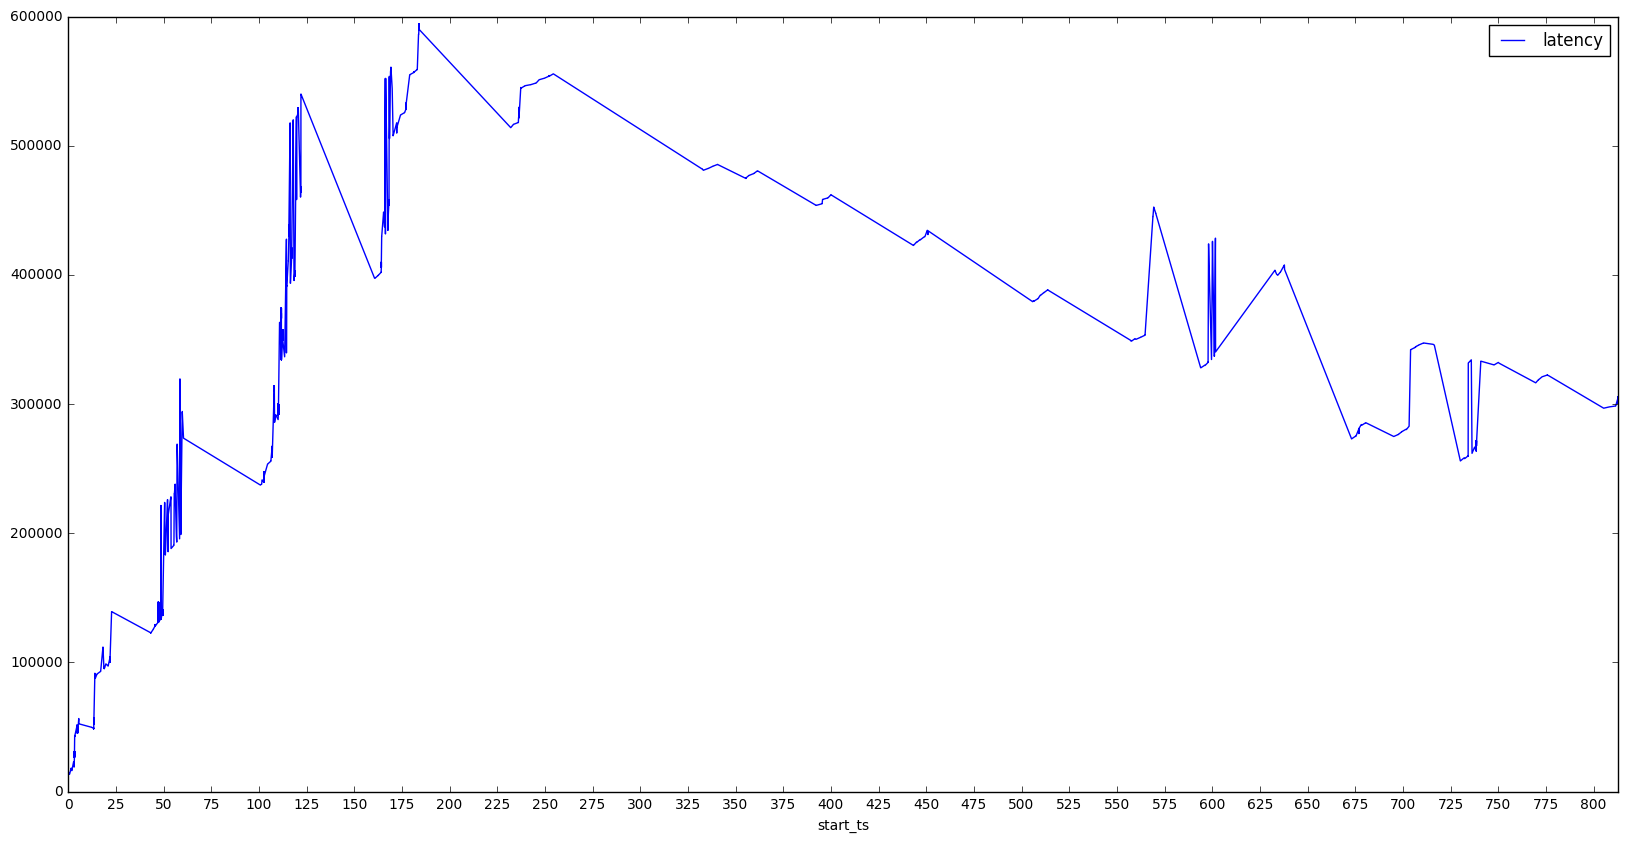

Latency quantile is:


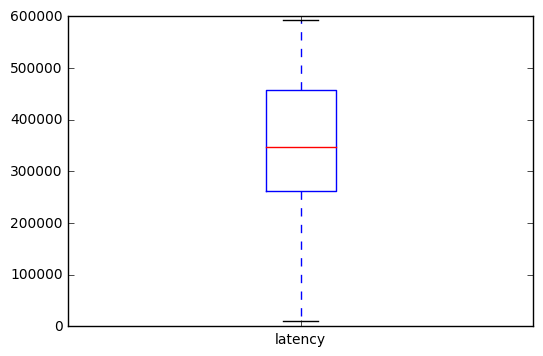

average latency is:
344847.255704
 window size quantile is:


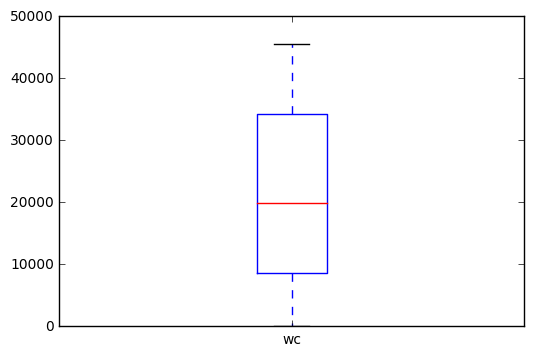

average window size is:
20788.9402838


In [29]:
temp_df  = buildDataFrame('/Users/jeka01/Desktop/temp/aggregation/4x/flink/flink_temp.csv')
df = pd.DataFrame({'latency':temp_df.latency, 'start_ts':temp_df.start_ts, 'wc':temp_df.wc},
                      columns=['latency','start_ts','wc'])
# df.plot.bar(y='latency', x = 'start_ts',figsize=(100,40))



# plt.show()

df = df.sort_values(by='start_ts', ascending=[True])
minEl = df.start_ts.iloc[0]
df['start_ts'] = df['start_ts'] - minEl
df['start_ts'] = df['start_ts'] /1000
df.plot.line(y='latency', x = 'start_ts',figsize=(20,10),xticks = np.arange(df.start_ts.min(),  df.start_ts.max(), 25))
plt.show()

print('Latency quantile is:')
df.latency.plot.box()
plt.show()
print('average latency is:')
print(df.latency.mean())

print(' window size quantile is:')
df.wc.plot.box()
plt.show()
print('average window size is:')
print(df.wc.mean())




In this figure Flink tries to ingest 4x max rate sockets. As it is seen, the tuples' latencies increase drammatically in first 200 seconds. Because of backpressure, the system can handle this and latencies go down as time proceeds.

This is sample behavior of Flink's backpressure.

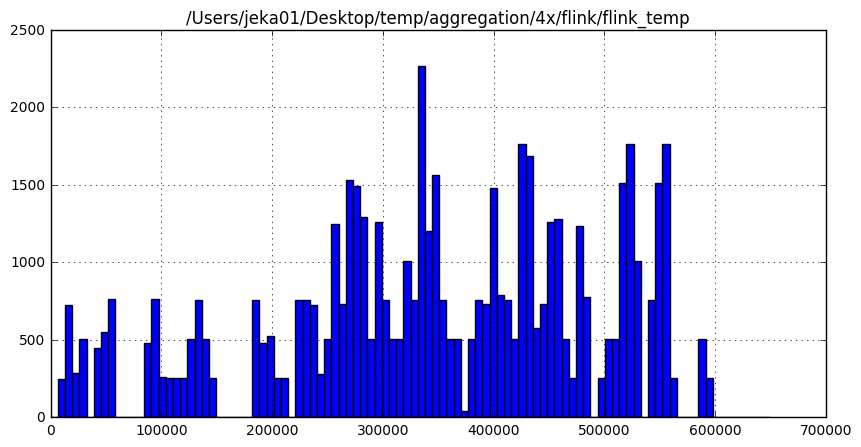

In [86]:
range = [0,650000]

pandasDraw([['/Users/jeka01/Desktop/temp/aggregation/4x/flink/flink_temp.csv']],
             _figsize=(10,5),_range=range)

plt.show()

This figure shows the tuples' latency frequency. Because the backpressure blocked the speed in first quarter of runtime, the remaining tuples in the queue are affected from this.

### Spark 4x
Spark gave an connection error for this configuration. Therefore the data generator statistics cannot be retrieved. The below figures show the performance of spark until crash. Note that the below experiments are stopped then crash occured and data processed is approximately 2/3 of whole input.

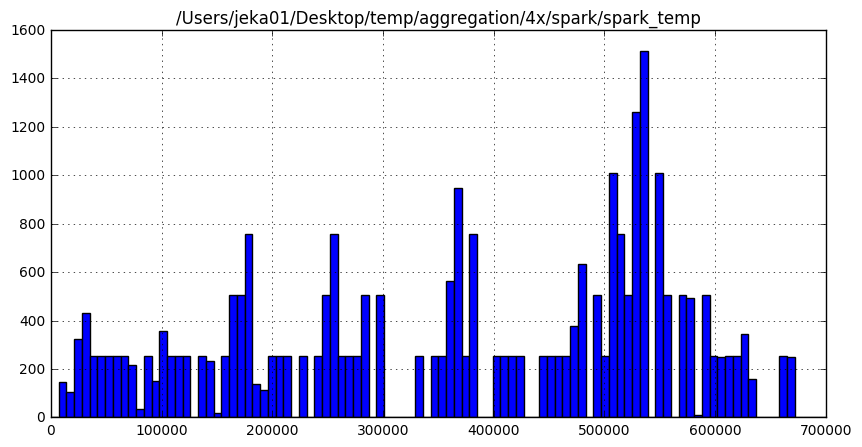

In [87]:
range = [0,700000]

pandasDraw([['/Users/jeka01/Desktop/temp/aggregation/4x/spark/spark_temp.csv']],
             _figsize=(10,5),_range=range)

plt.show()

There is a slight difference between Spark 4x and Flink 4x. Flink performs a little better. However, we have to take into account that this is the result of 2/3 data that Flink processed. 

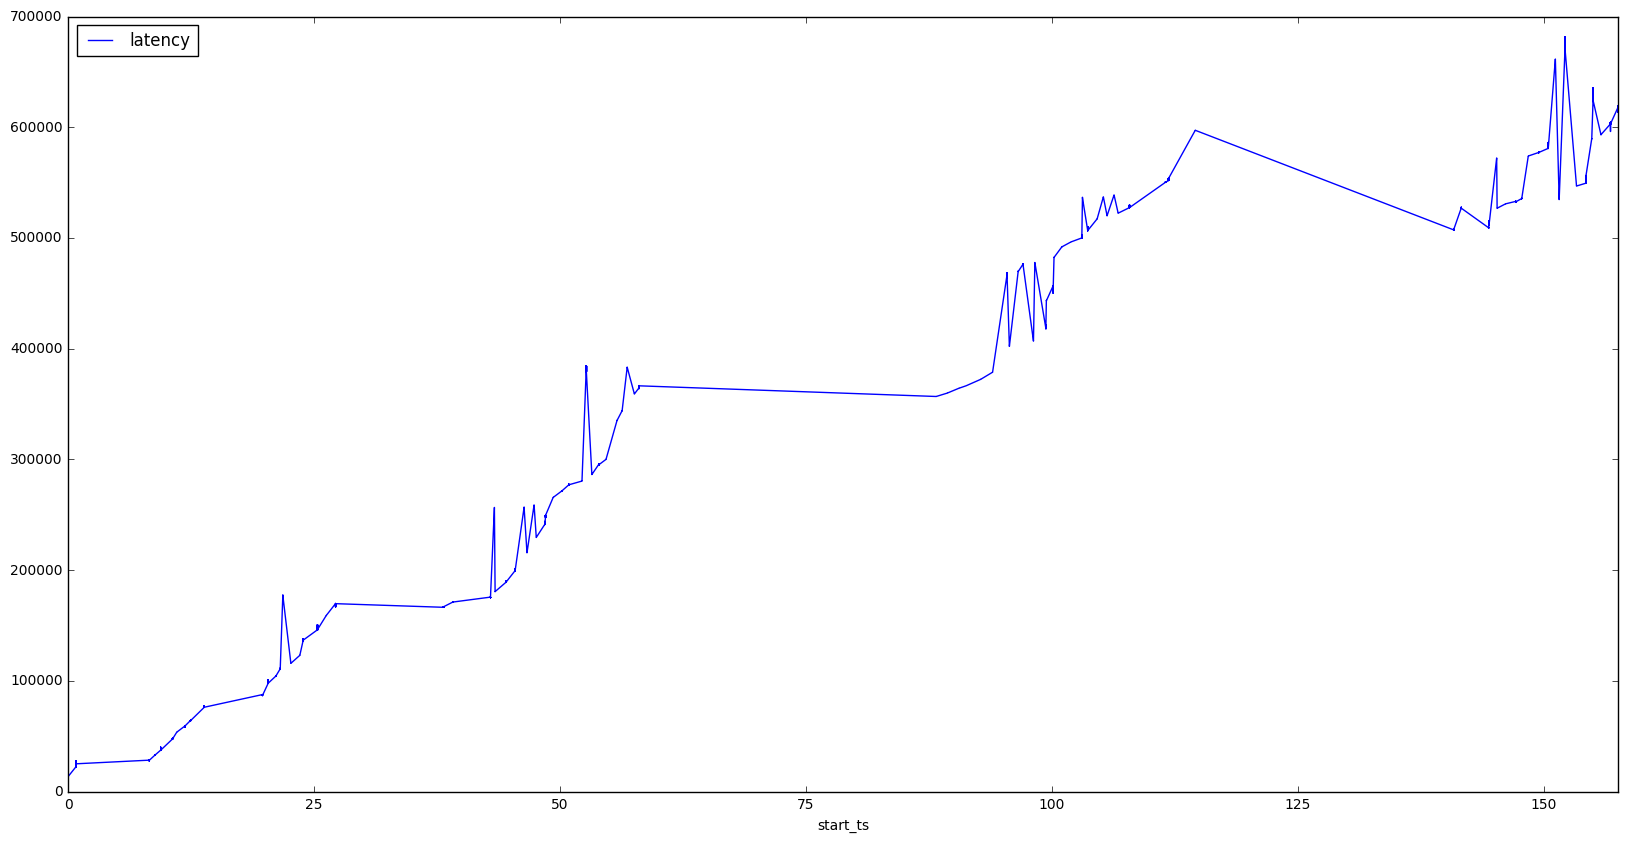

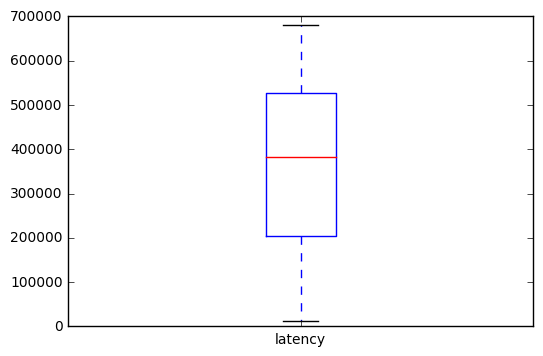

average latency is:
367293.542907
 window size quantile is:


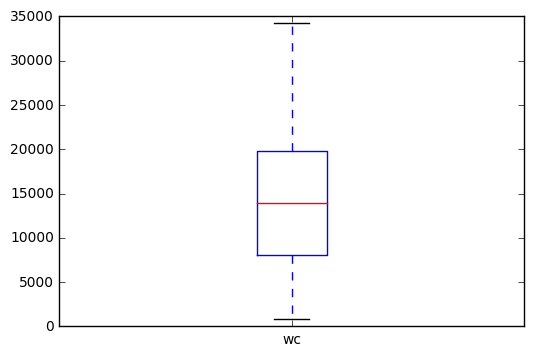

average window size is:
14072.7440122


In [32]:
temp_df  = buildDataFrame('/Users/jeka01/Desktop/temp/aggregation/4x/spark/spark_temp.csv')
df = pd.DataFrame({'latency':temp_df.latency, 'start_ts':temp_df.start_ts,'wc':temp_df.wc},
                      columns=['latency','start_ts','wc'])
# df.plot.bar(y='latency', x = 'start_ts',figsize=(100,40))

# plt.show()

df = df.sort_values(by='start_ts', ascending=[True])
minEl = df.start_ts.iloc[0]
df['start_ts'] = df['start_ts'] - minEl
df['start_ts'] = df['start_ts'] /1000
df.plot.line(y='latency', x = 'start_ts',figsize=(20,10),xticks = np.arange(df.start_ts.min(),  df.start_ts.max(), 25))

plt.show()
df.latency.plot.box()
plt.show()

print('average latency is:')
print(df.latency.mean())


print(' window size quantile is:')
df.wc.plot.box()
plt.show()
print('average window size is:')
print(df.wc.mean())





This figure shows the latency of outputted elements  in increasing order of their timestamp. Here we can see that Spark didn't handled backpressure efficiently and probably that was the reason that it crashed. 

### Spark 2x


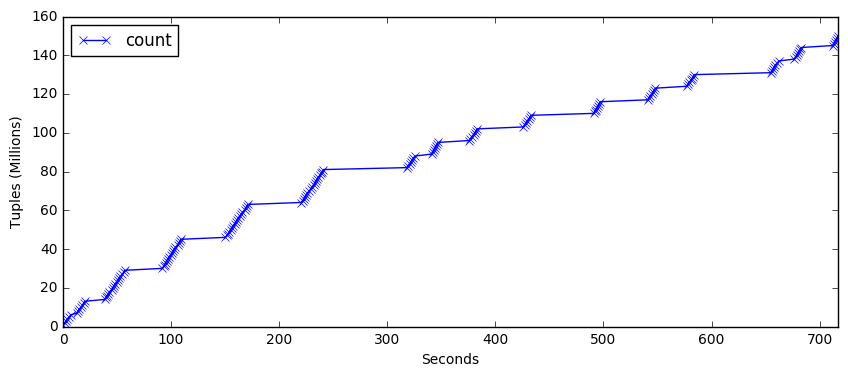

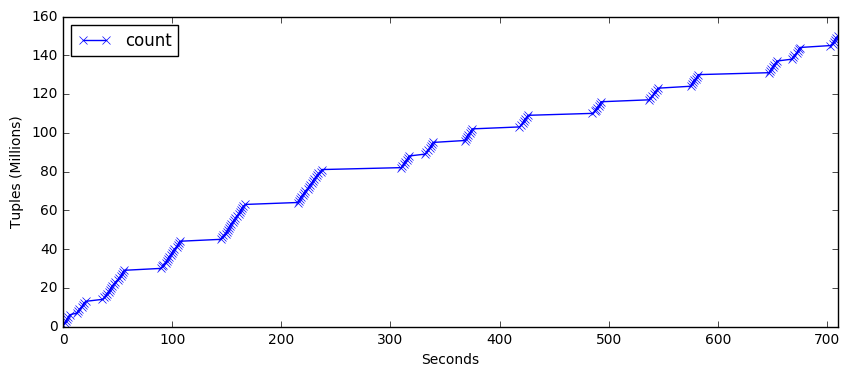

In [4]:
dataGeneratorStatsSeparateOneAxis('/Users/jeka01/Desktop/temp/stats/2x/spark/datarate',(10,4),'Seconds','Tuples (Millions)',100)

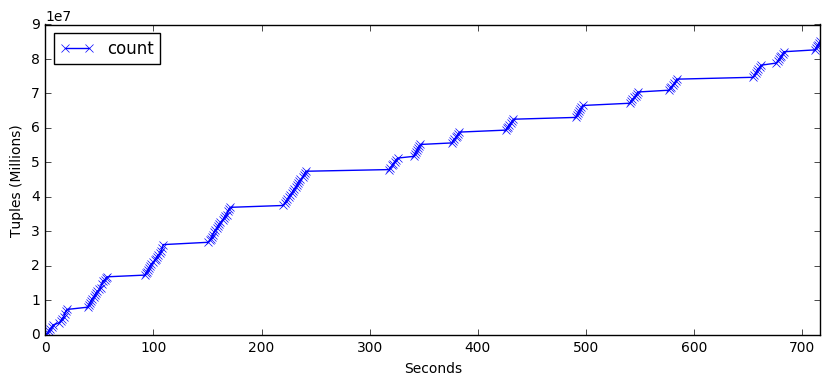

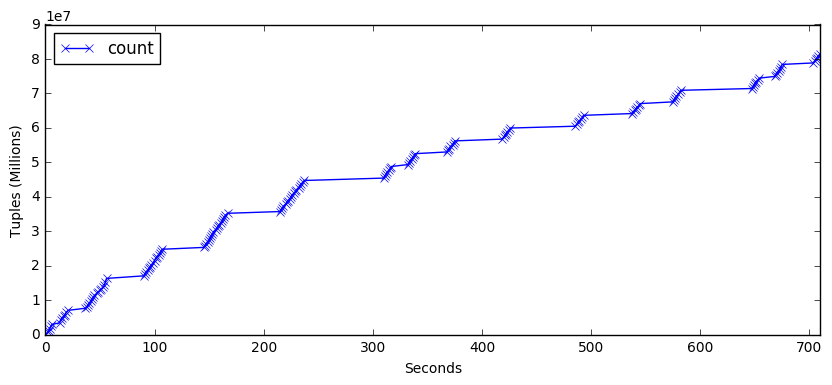

In [6]:
dataGeneratorStatsSeparate('/Users/jeka01/Desktop/temp/stats/2x/spark/buffer',(10,4),'Seconds','Tuples (Millions)',100)



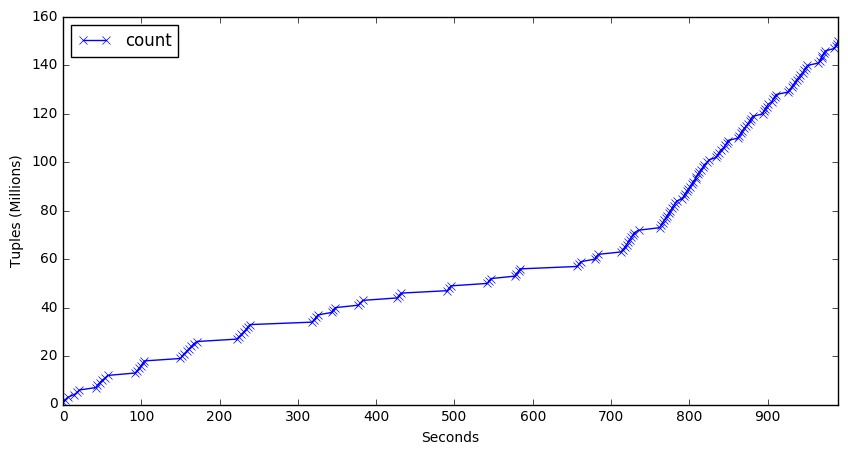

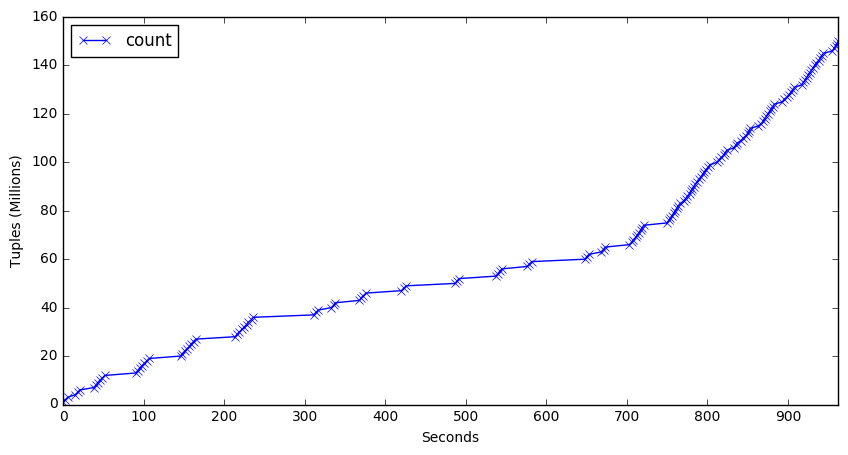

In [7]:
dataGeneratorStatsSeparateOneAxis('/Users/jeka01/Desktop/temp/stats/2x/spark/thoughput',(10,5),'Seconds','Tuples (Millions)',100)

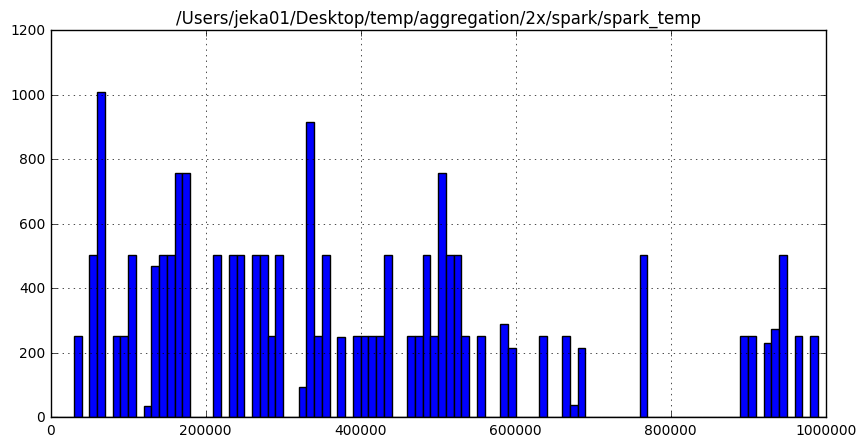

In [8]:
range = [0,1000000]

pandasDraw([['/Users/jeka01/Desktop/temp/aggregation/2x/spark/spark_temp.csv']],
             _figsize=(10,5),_range=range)

plt.show()

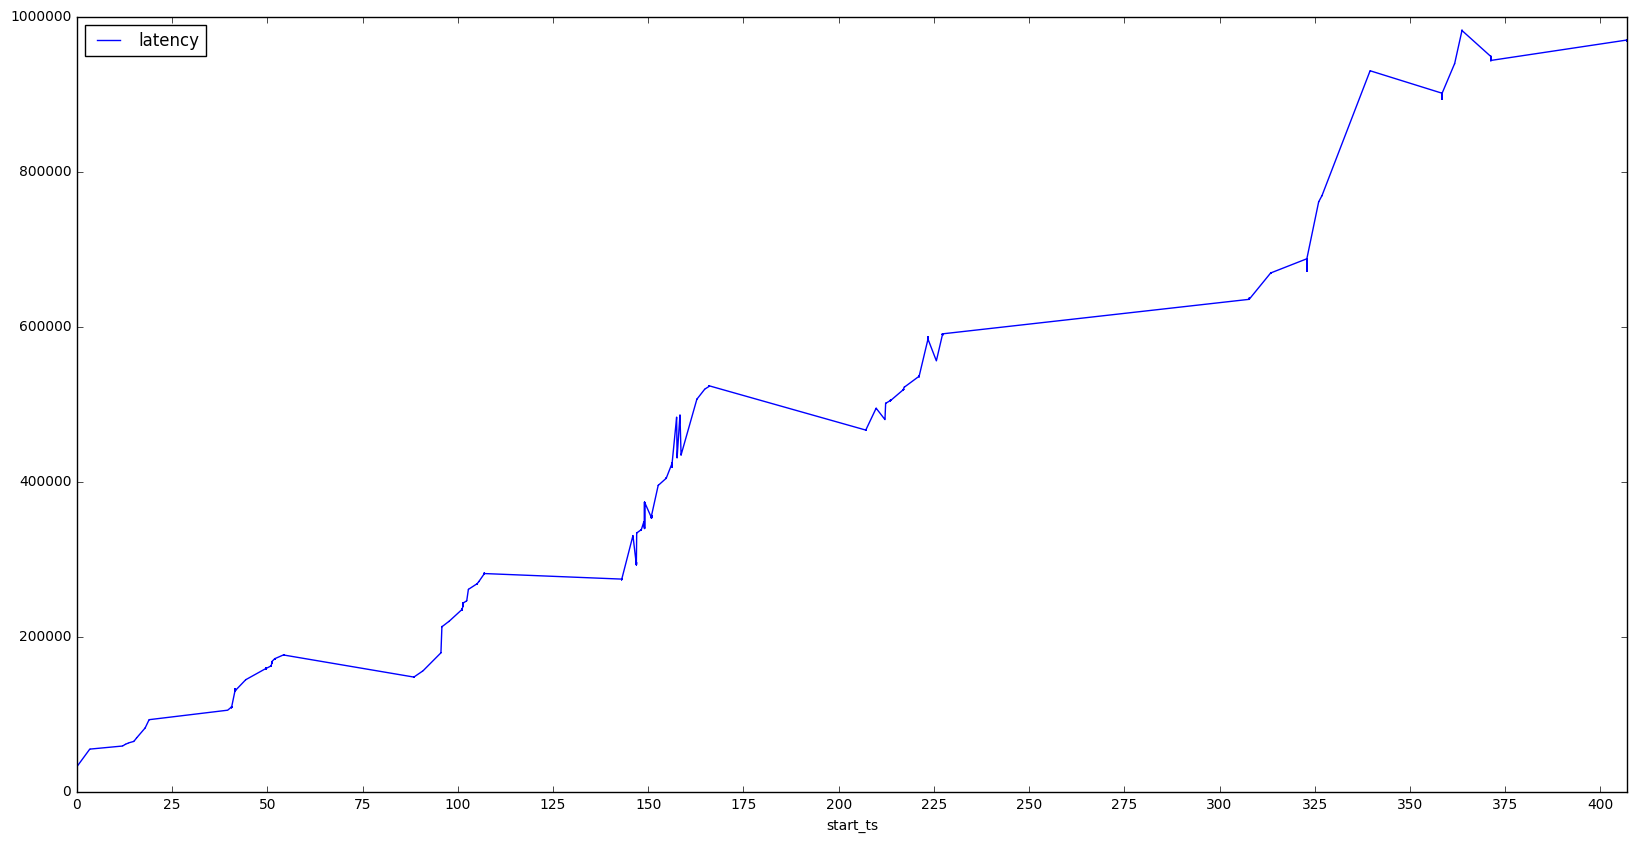

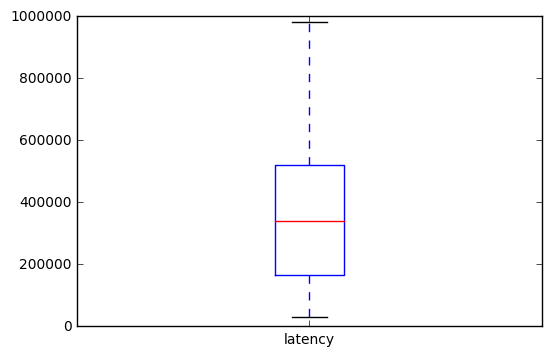

average latency is:
387225.697965
 window size quantile is:


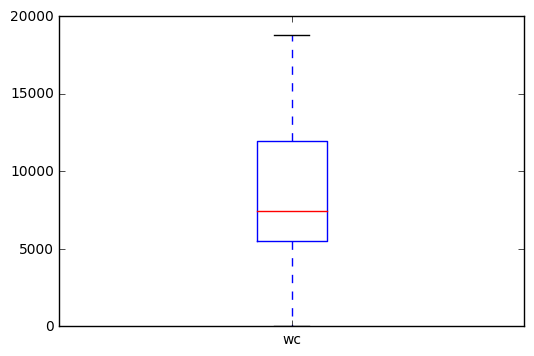

average window size is:
8542.87676463


In [33]:
temp_df  = buildDataFrame('/Users/jeka01/Desktop/temp/aggregation/2x/spark/spark_temp.csv')
df = pd.DataFrame({'latency':temp_df.latency, 'start_ts':temp_df.start_ts,'wc':temp_df.wc},
                      columns=['latency','start_ts','wc'])

df = df.sort_values(by='start_ts', ascending=[True])
minEl = df.start_ts.iloc[0]
df['start_ts'] = df['start_ts'] - minEl
df['start_ts'] = df['start_ts'] /1000
df.plot.line(y='latency', x = 'start_ts',figsize=(20,10),xticks = np.arange(df.start_ts.min(),  df.start_ts.max(), 25))

plt.show()
df.latency.plot.box()
plt.show()
print('average latency is:')
print(df.latency.mean())

print(' window size quantile is:')
df.wc.plot.box()
plt.show()
print('average window size is:')
print(df.wc.mean())




### Flink 2x

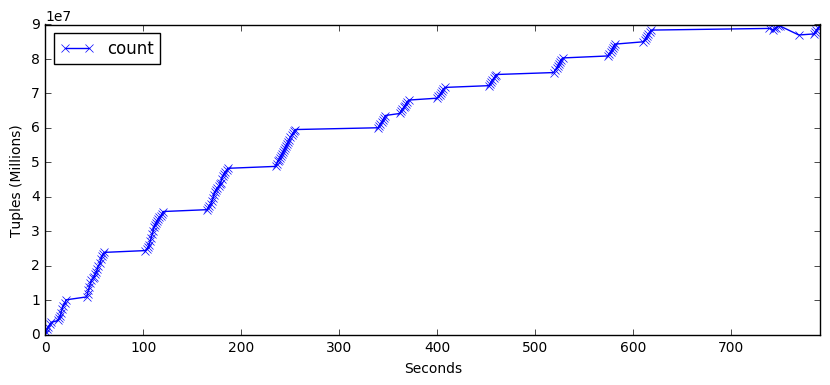

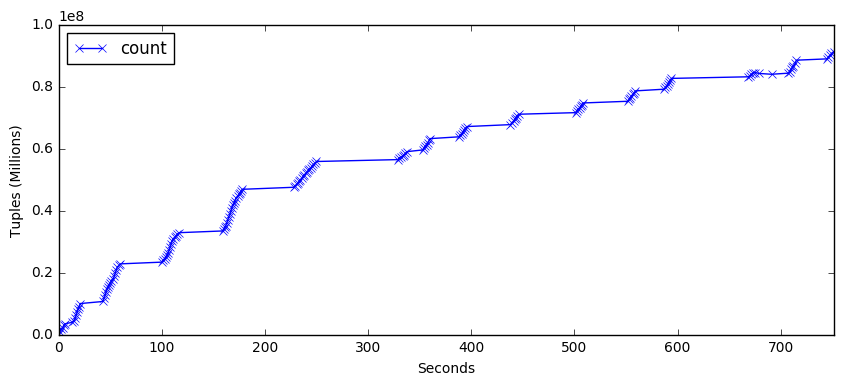

In [3]:
dataGeneratorStatsSeparate('/Users/jeka01/Desktop/temp/stats/2x/flink/buffer',(10,4),'Seconds','Tuples (Millions)',100)


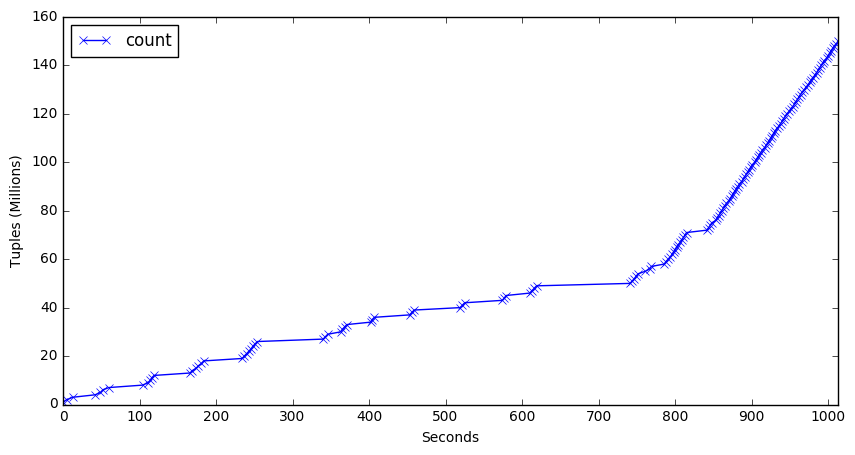

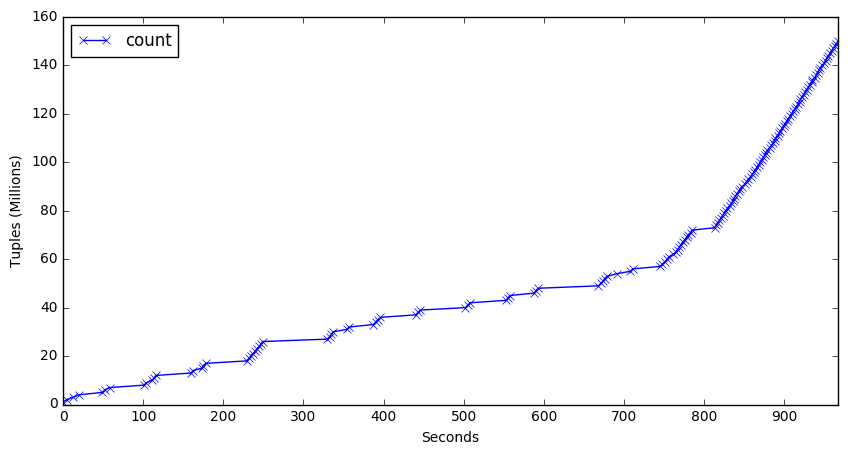

In [4]:
dataGeneratorStatsSeparateOneAxis('/Users/jeka01/Desktop/temp/stats/2x/flink/thoughput',(10,5),'Seconds','Tuples (Millions)',100)


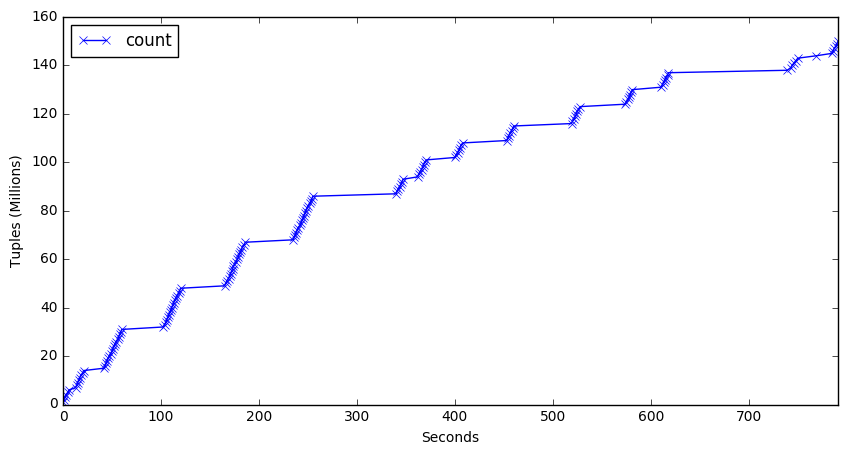

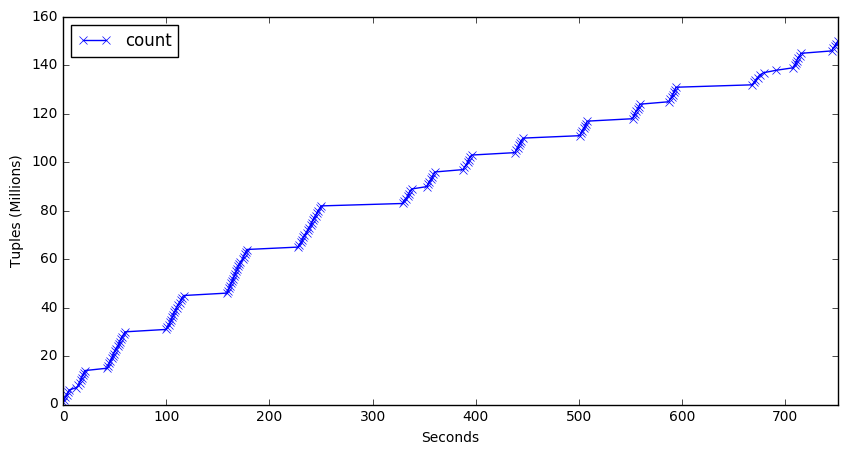

In [5]:
dataGeneratorStatsSeparateOneAxis('/Users/jeka01/Desktop/temp/stats/2x/flink/datarate',(10,5),'Seconds','Tuples (Millions)',100)



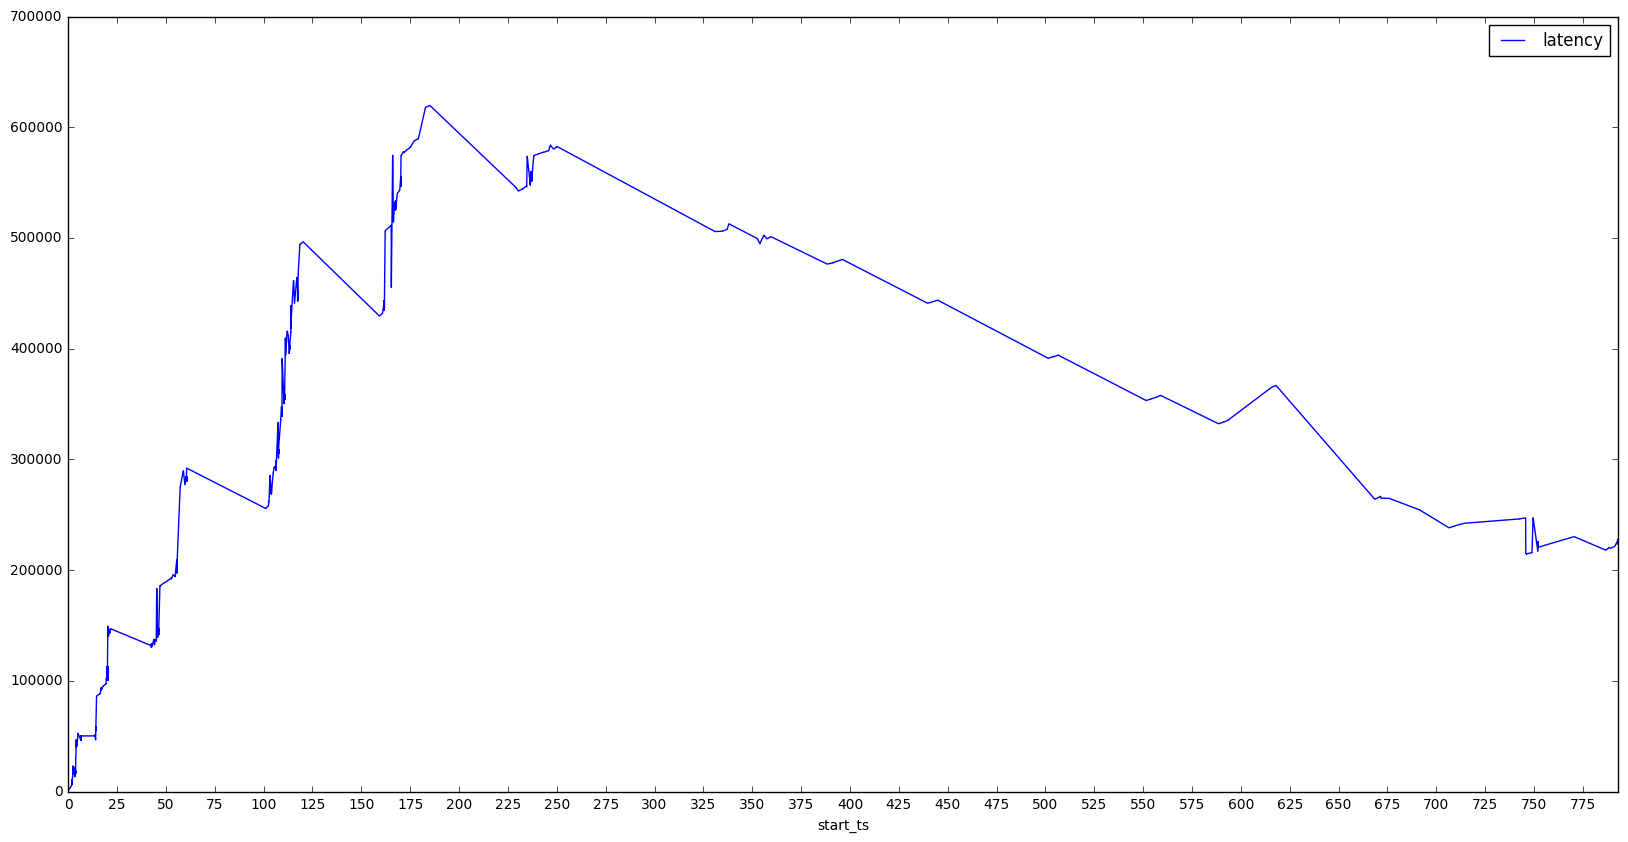

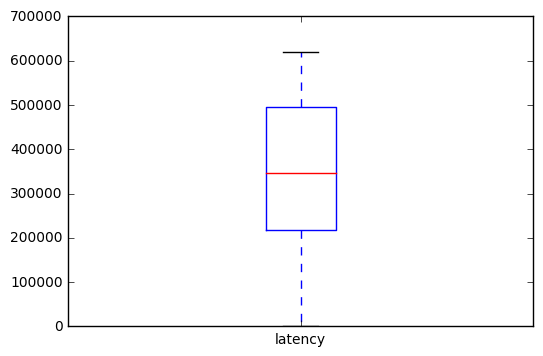

average latency is:
337102.687623
 window size quantile is:


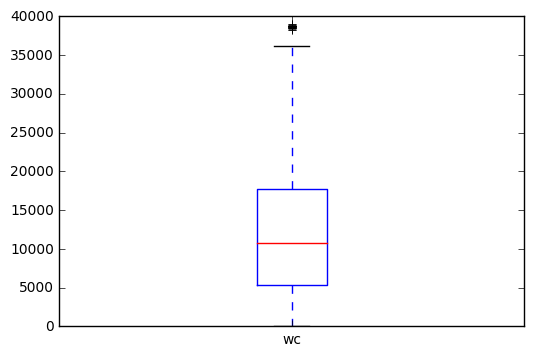

average window size is:
12953.6475313


In [34]:
temp_df  = buildDataFrame('/Users/jeka01/Desktop/temp/aggregation/2x/flink/flink_temp.csv')
df = pd.DataFrame({'latency':temp_df.latency, 'start_ts':temp_df.start_ts,'wc':temp_df.wc},
                      columns=['latency','start_ts','wc'])
# df.plot.bar(y='latency', x = 'start_ts',figsize=(100,40))

# plt.show()



df = df.sort_values(by='start_ts', ascending=[True])
minEl = df.start_ts.iloc[0]
df['start_ts'] = df['start_ts'] - minEl
df['start_ts'] = df['start_ts'] /1000
df.plot.line(y='latency', x = 'start_ts',figsize=(20,10),xticks = np.arange(df.start_ts.min(),  df.start_ts.max(), 25))

plt.show()
df.latency.plot.box()
plt.show()
print('average latency is:')
print(df.latency.mean())

print(' window size quantile is:')
df.wc.plot.box()
plt.show()
print('average window size is:')
print(df.wc.mean())





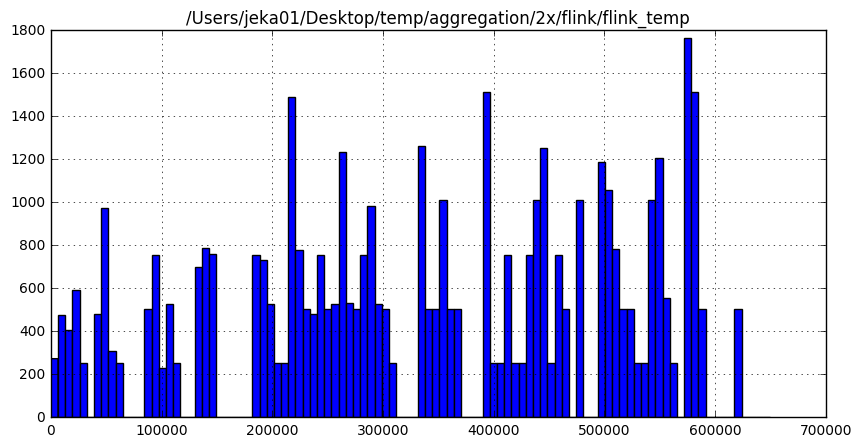

In [7]:
range = [0,650000]

pandasDraw([['/Users/jeka01/Desktop/temp/aggregation/2x/flink/flink_temp.csv']],
             _figsize=(10,5),_range=range)

plt.show()


### Trident 1x

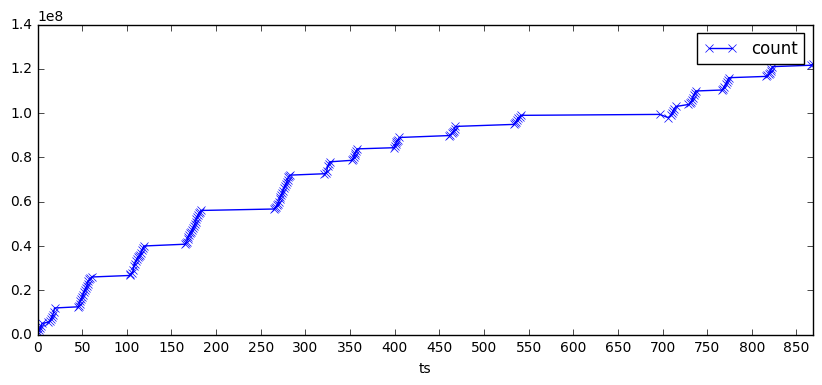

In [64]:
dataGeneratorStatsSeparate('/Users/jeka01/Desktop/temp/stats/1x/trident/buffer',(10,4))



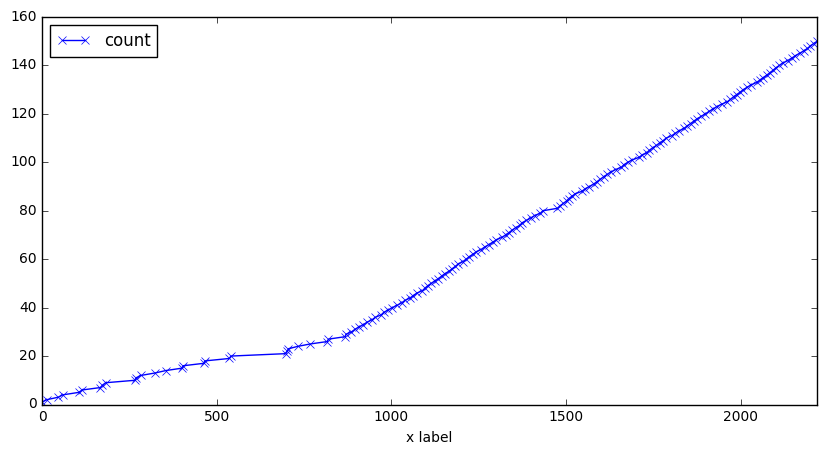

In [11]:
dataGeneratorStatsSeparateOneAxis('/Users/jeka01/Desktop/temp/stats/1x/trident/thoughput',(10,5))



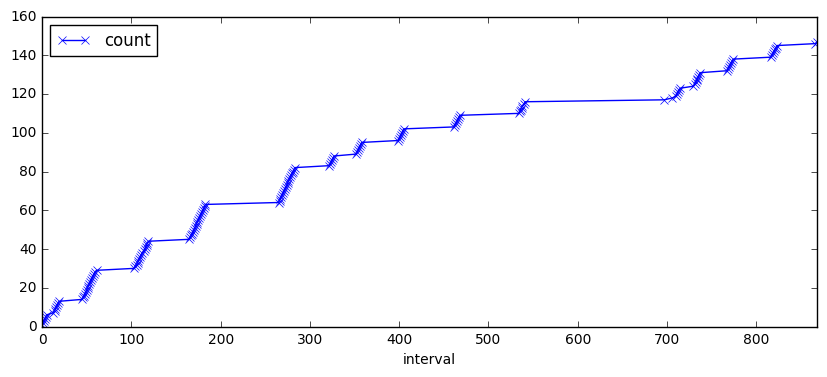

In [6]:
dataGeneratorStatsSeparateOneAxis('/Users/jeka01/Desktop/temp/stats/1x/trident/datarate',(10,4))



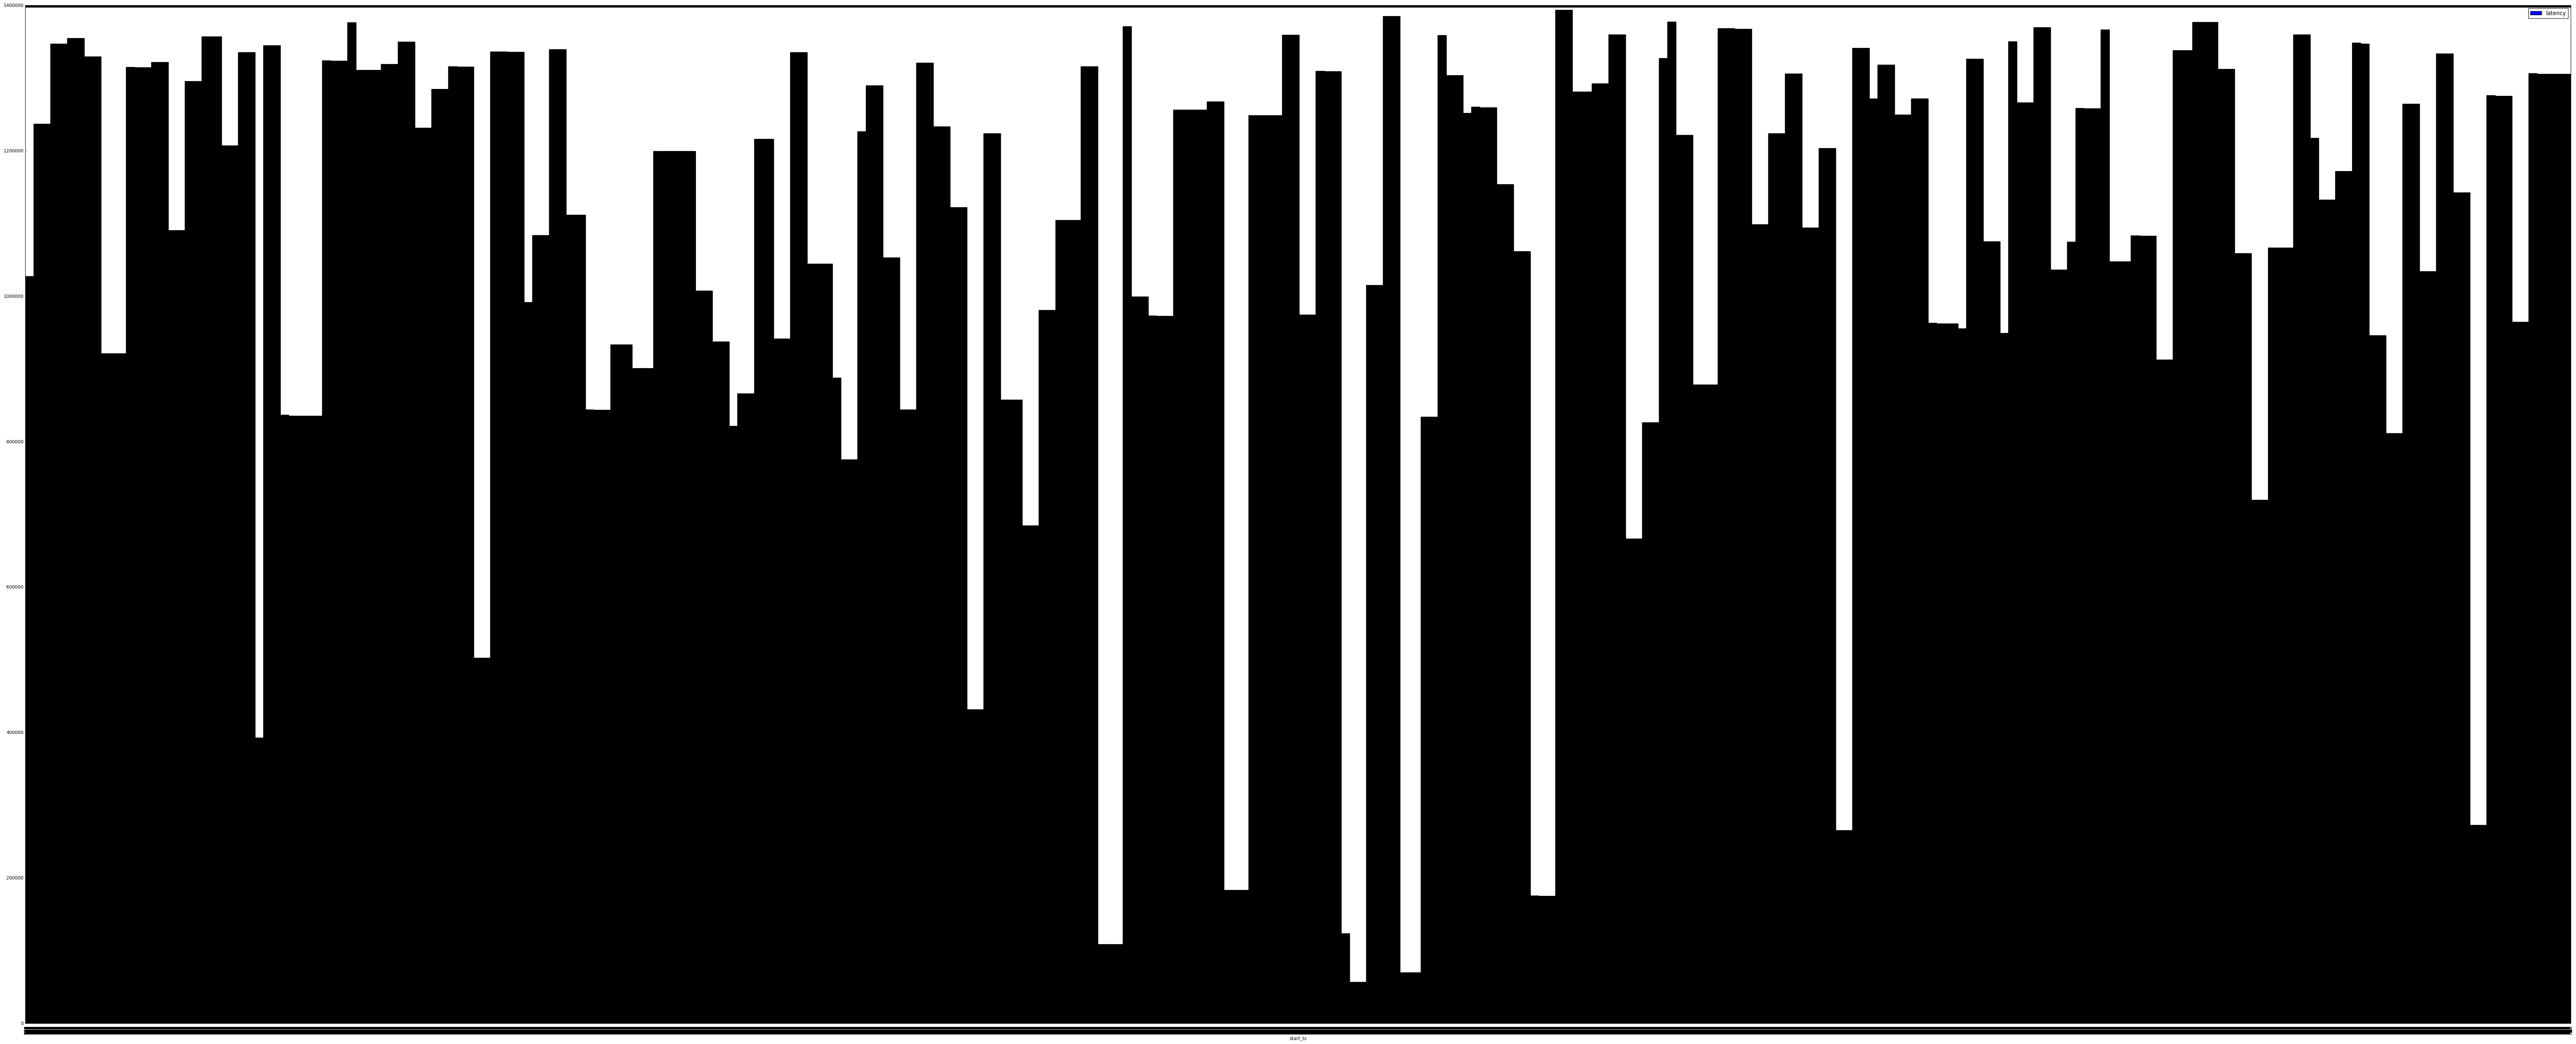

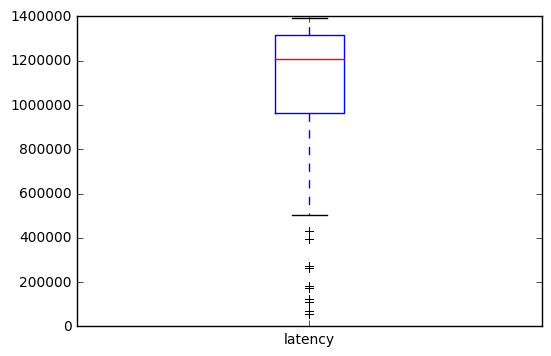

average latency is:
1086295.64595


In [17]:
temp_df  = buildDataFrame('/Users/jeka01/Desktop/temp/aggregation/1x/trident/trident_temp.csv')
df = pd.DataFrame({'latency':temp_df.latency, 'start_ts':temp_df.start_ts},
                      columns=['latency','start_ts'])
df.plot.bar(y='latency', x = 'start_ts',figsize=(100,40))

plt.show()


df.latency.plot.box()
plt.show()
print('average latency is:')
print(df.latency.mean())






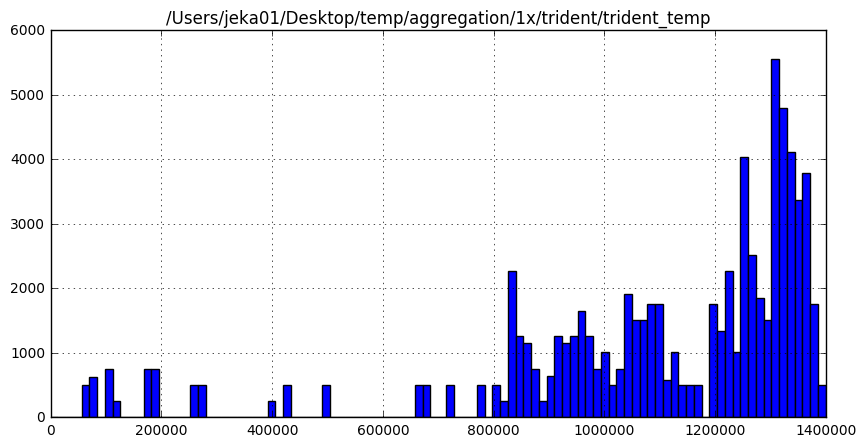

In [16]:
range = [0,1400000]

pandasDraw([['/Users/jeka01/Desktop/temp/aggregation/1x/trident/trident_temp.csv']],
             _figsize=(10,5),_range=range)

plt.show()

 window size quantile is:


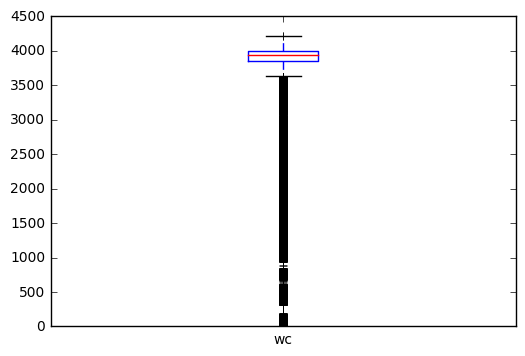

average window size is:
3422.84130936


In [35]:
temp_df  = buildDataFrame('/Users/jeka01/Desktop/temp/aggregation/1x/trident/trident_temp.csv')
df = pd.DataFrame({'latency':temp_df.latency, 'start_ts':temp_df.start_ts,'wc':temp_df.wc},
                      columns=['latency','start_ts','wc'])

print(' window size quantile is:')
df.wc.plot.box()
plt.show()
print('average window size is:')
print(df.wc.mean())



# Introduction

Stream Data Processing Systems (SDPS)is designed to do transformations and query continuous data streams. It is similar to a database management system (DBMS), which is, however, designed for static data in conventional databases.
There are several open source SDPS which are used both by academia and industry. In this work, we picked Apache Storm, Apache Spark and Apache Flink to compare their performances in terms of latency and thoughput. 

# Wrong results



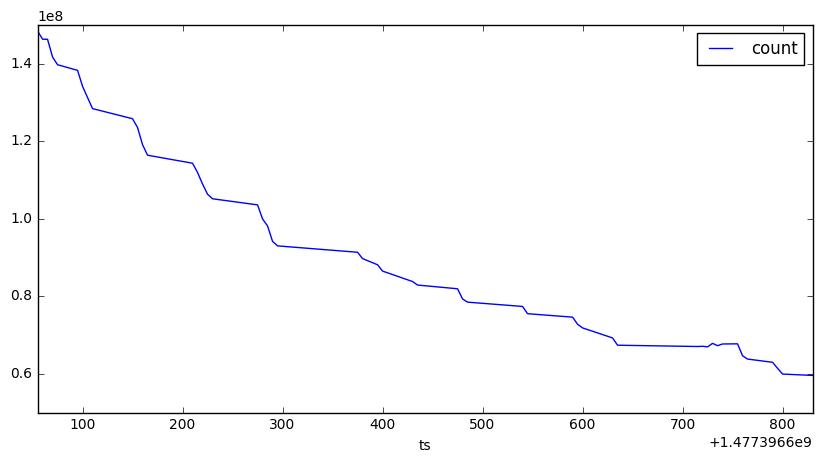

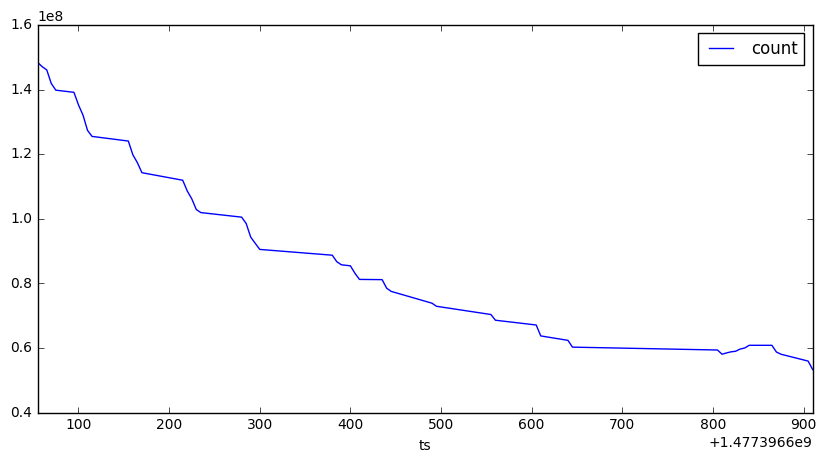

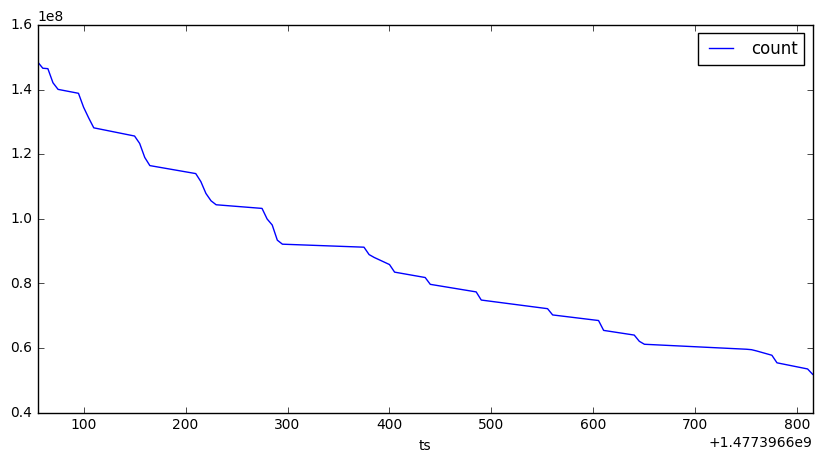

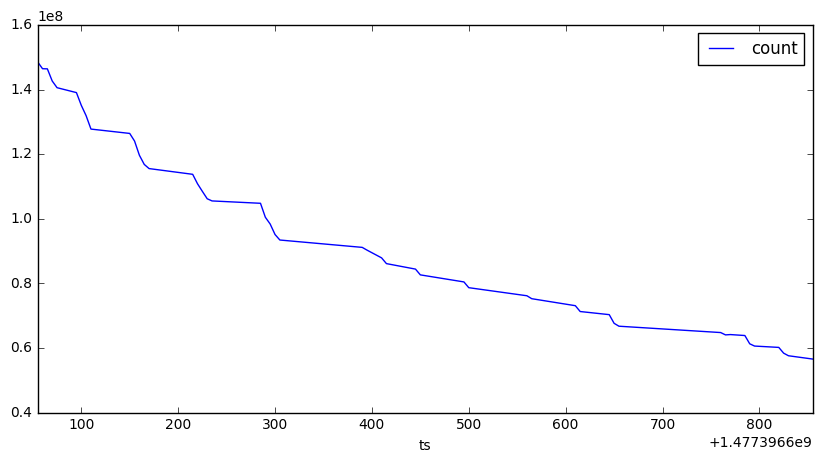

In [201]:
df = dataGeneratorStatsSeparate('/Users/jeka01/Desktop/temp/stats/4x/wrong/buffer',(10,5))




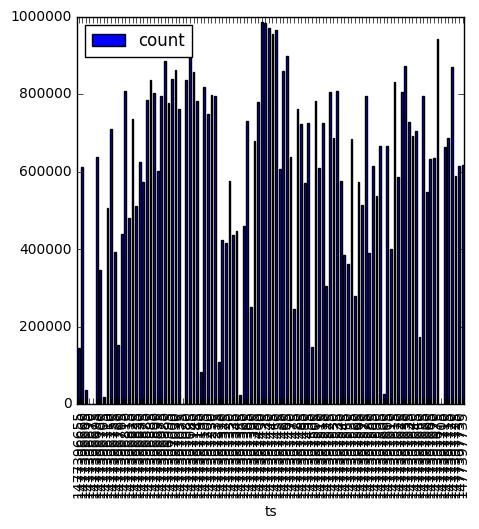

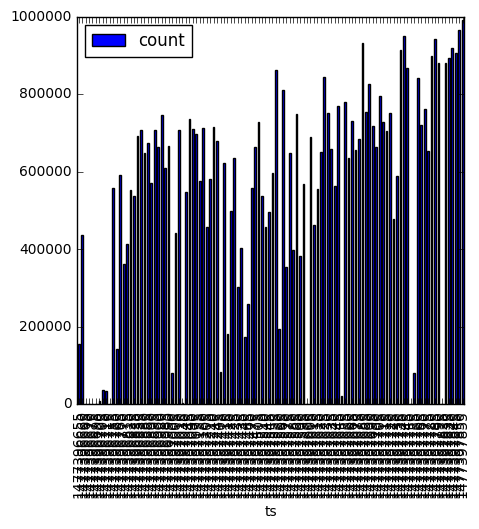

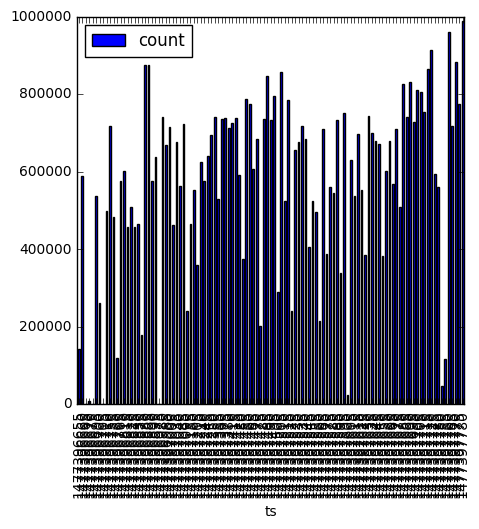

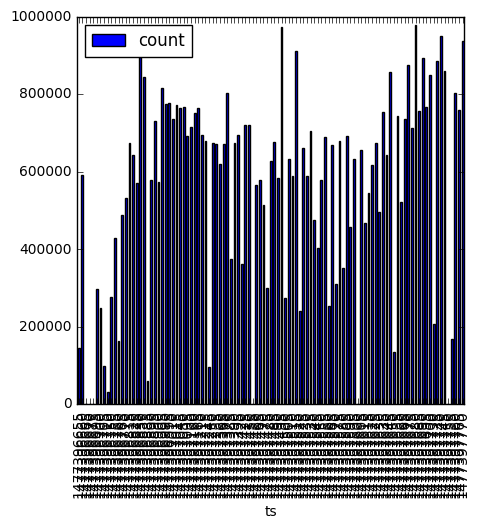

In [193]:
dataGeneratorStatsSeparate('/Users/jeka01/Desktop/temp/stats/4x/wrong/thoughput',(5,5))


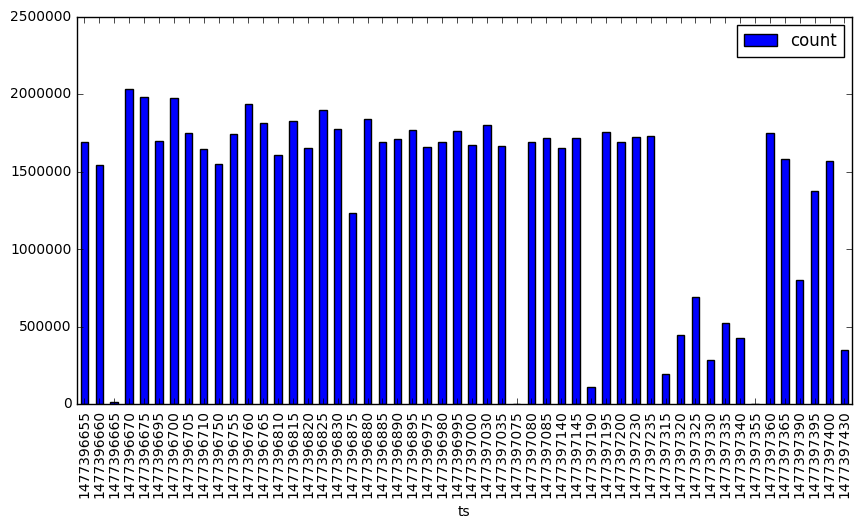

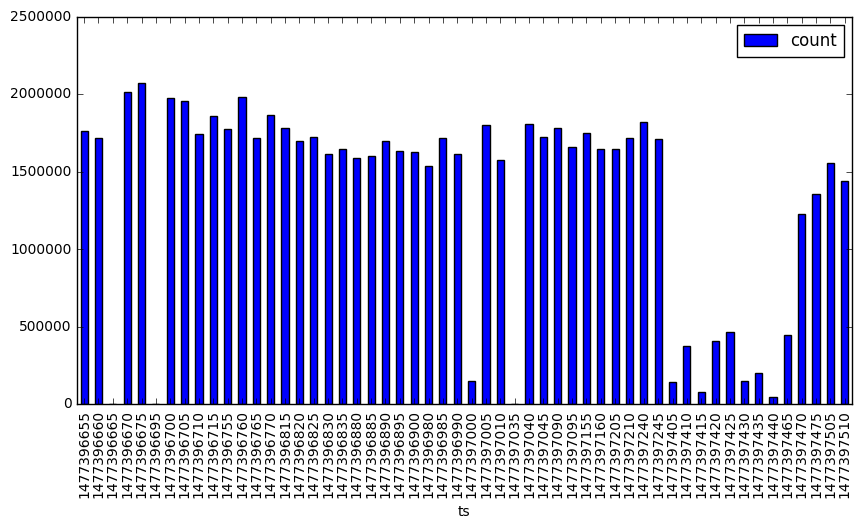

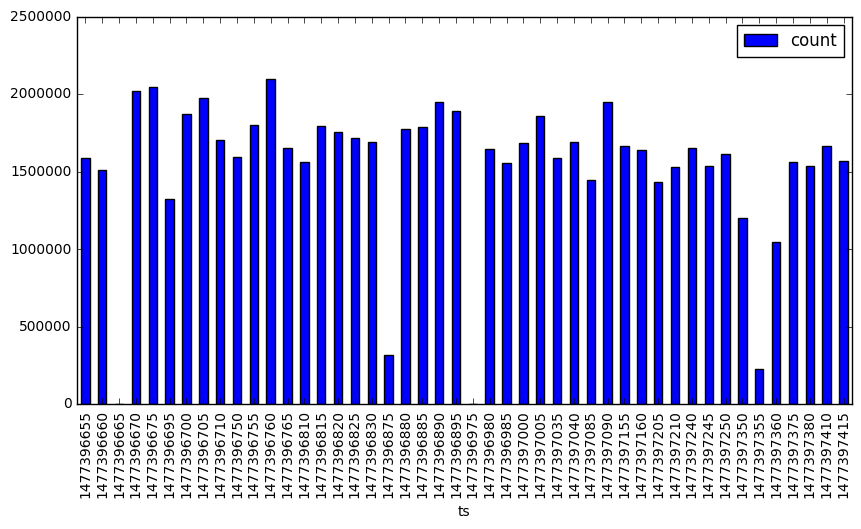

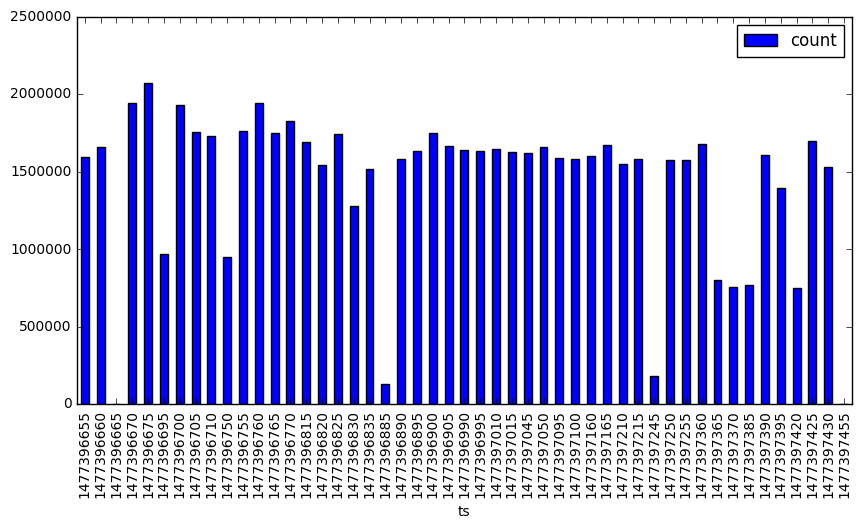

In [195]:
dataGeneratorStatsSeparate('/Users/jeka01/Desktop/temp/stats/4x/wrong/datarate',(10,5))


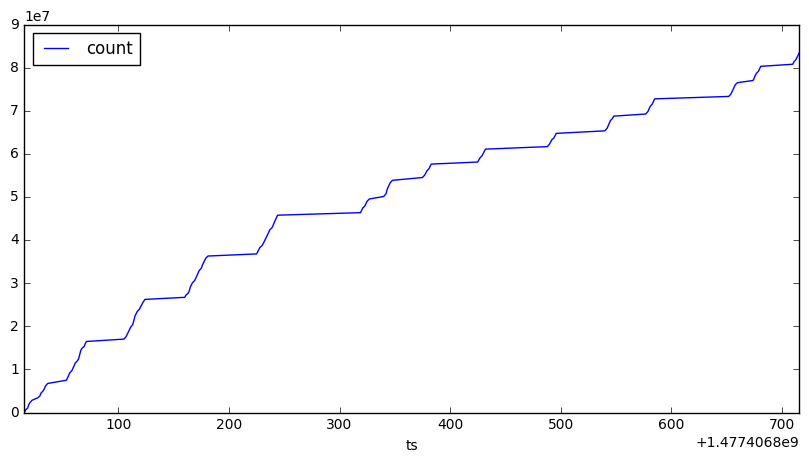

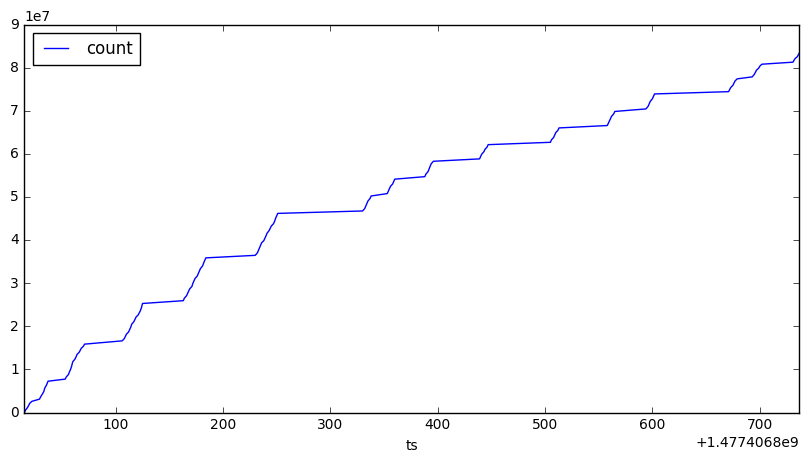

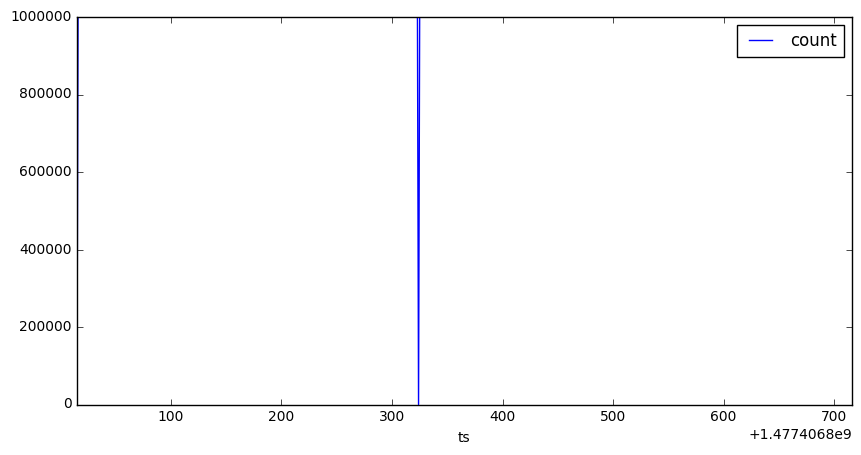

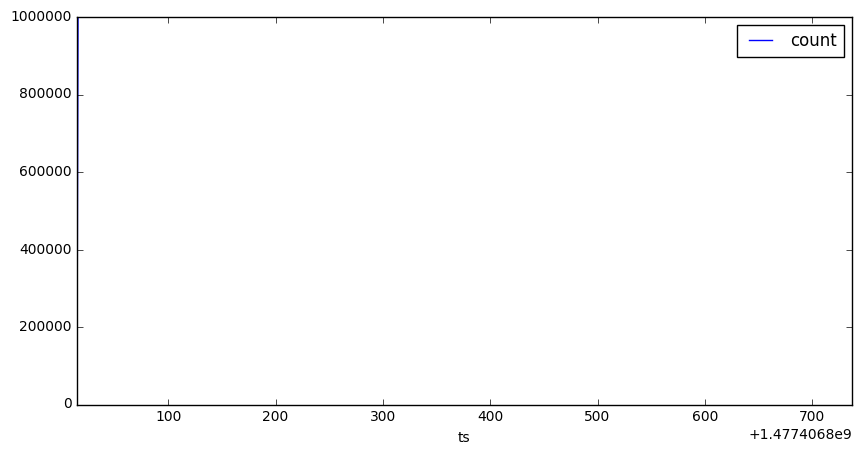

In [205]:
dataGeneratorStatsSeparate('/Users/jeka01/Desktop/temp/stats/2x/spark/datarate',(10,5))



In [212]:
dataGeneratorStatsSeparateOneAxis('/Users/jeka01/Desktop/temp/stats/2x/spark/thoughput',(10,5))



             ts
29   1477406815
54   1477406818
56   1477406821
43   1477406829
63   1477406832
136  1477406835
74   1477406854
76   1477406857
78   1477406860
80   1477406863
83   1477406867
51   1477406870
103  1477406906
104  1477406908
107  1477406911
110  1477406916
112  1477406919
113  1477406921
138  1477406960
139  1477406962
140  1477406965
143  1477406968
145  1477406970
147  1477406973
0    1477406976
2    1477406979
21   1477407024
22   1477407027
24   1477407029
45   1477407032
..          ...
108  1477407681
109  1477407683
111  1477407685
141  1477407687
114  1477407690
115  1477407691
117  1477407693
121  1477407703
122  1477407705
123  1477407707
20   1477407709
125  1477407711
127  1477407713
129  1477407716
130  1477407717
132  1477407720
134  1477407722
41   1477407724
87   1477407735
119  1477407737
133  1477407740
137  1477407741
149  1477407743
1    1477407746
3    1477407748
5    1477407750
7    1477407760
8    1477407762
9    1477407764
10   1477407766

[150 ro

KeyError: 'count'

Flink
Data generation rate into buffer: 210K ps
Memory allocation- 8G per each node
x axis indicates the latency of tuples
y axis indicates the number of tuples with specified latency


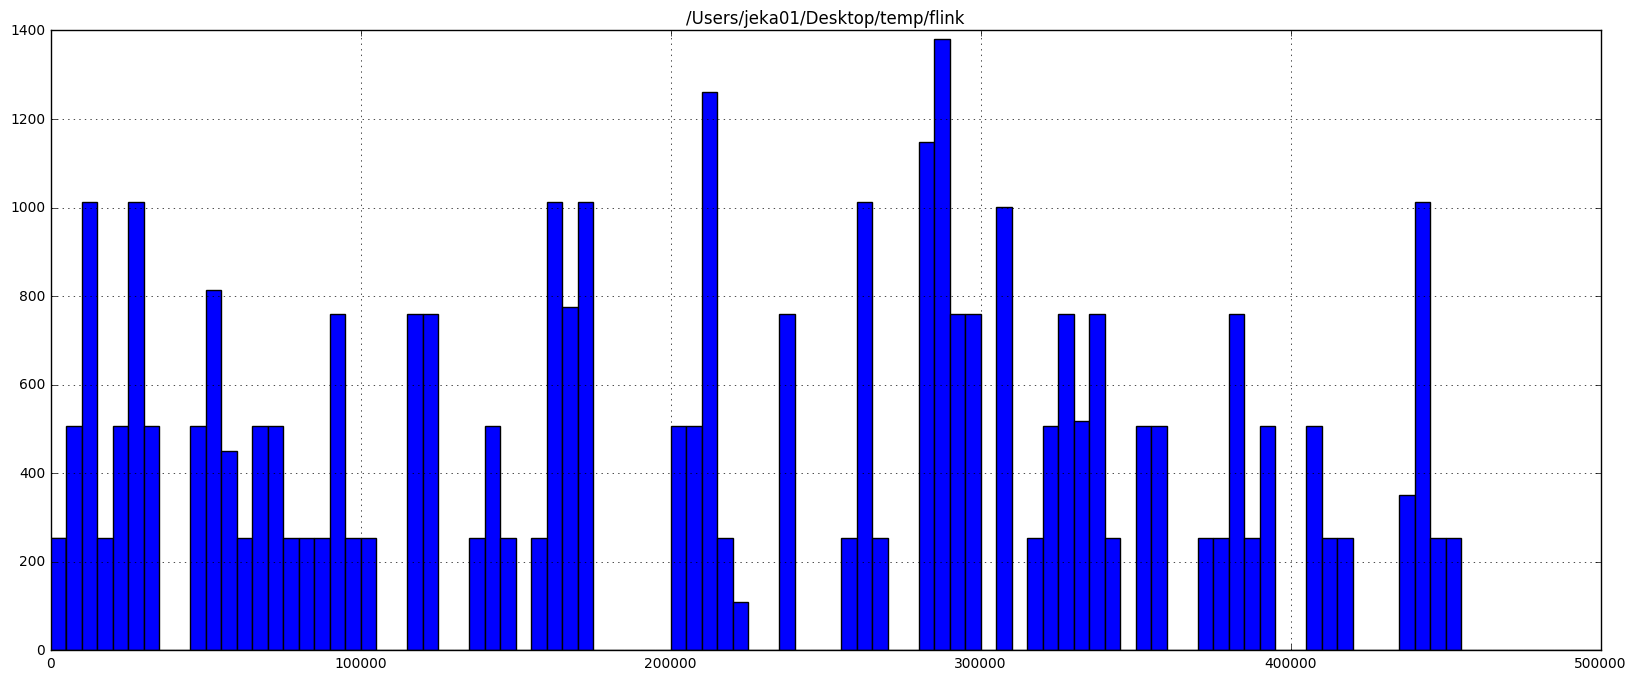

In [6]:
# print('Flink')
# print('Data generation rate into buffer: 210K ps')
# print('Memory allocation- 8G per each node')
# print('x axis indicates the latency of tuples')
# print('y axis indicates the number of tuples with specified latency')




# figsize = (20,8)
# range = [0,500000]
# # temp_df  = buildDataFrame('/Users/jeka01/Desktop/temp/atempfile.csv')
# # df = pd.DataFrame({'latency':temp_df.latency, 'index_col':temp_df.index_col},
# #                     columns=['latency','index_col'])


# #df.plot.bar(y='latency', x = 'index_col',figsize=(200,40))
# #print(df.lateindex_colncy)
# #x = x.reset_index()
# #x = x.groupby(x['index_col'].div(3)).mean()


# # pandasDraw([['/Users/jeka01/Desktop/temp/tempfile.csv']],
# #             _figsize=figsize,_range=range)
# # range = [0,5000]

# pandasDraw([['/Users/jeka01/Desktop/temp/flink.csv']],
#             _figsize=figsize,_range=range)

# plt.show()




Flink
Data generation rate into buffer: 210K ps
Memory allocation- 8G per each node
x axis indicates the generation time of tuple
y axis indicates the latency of the tuple with given generation time
This can be thought as the visualization of latencies as we progress


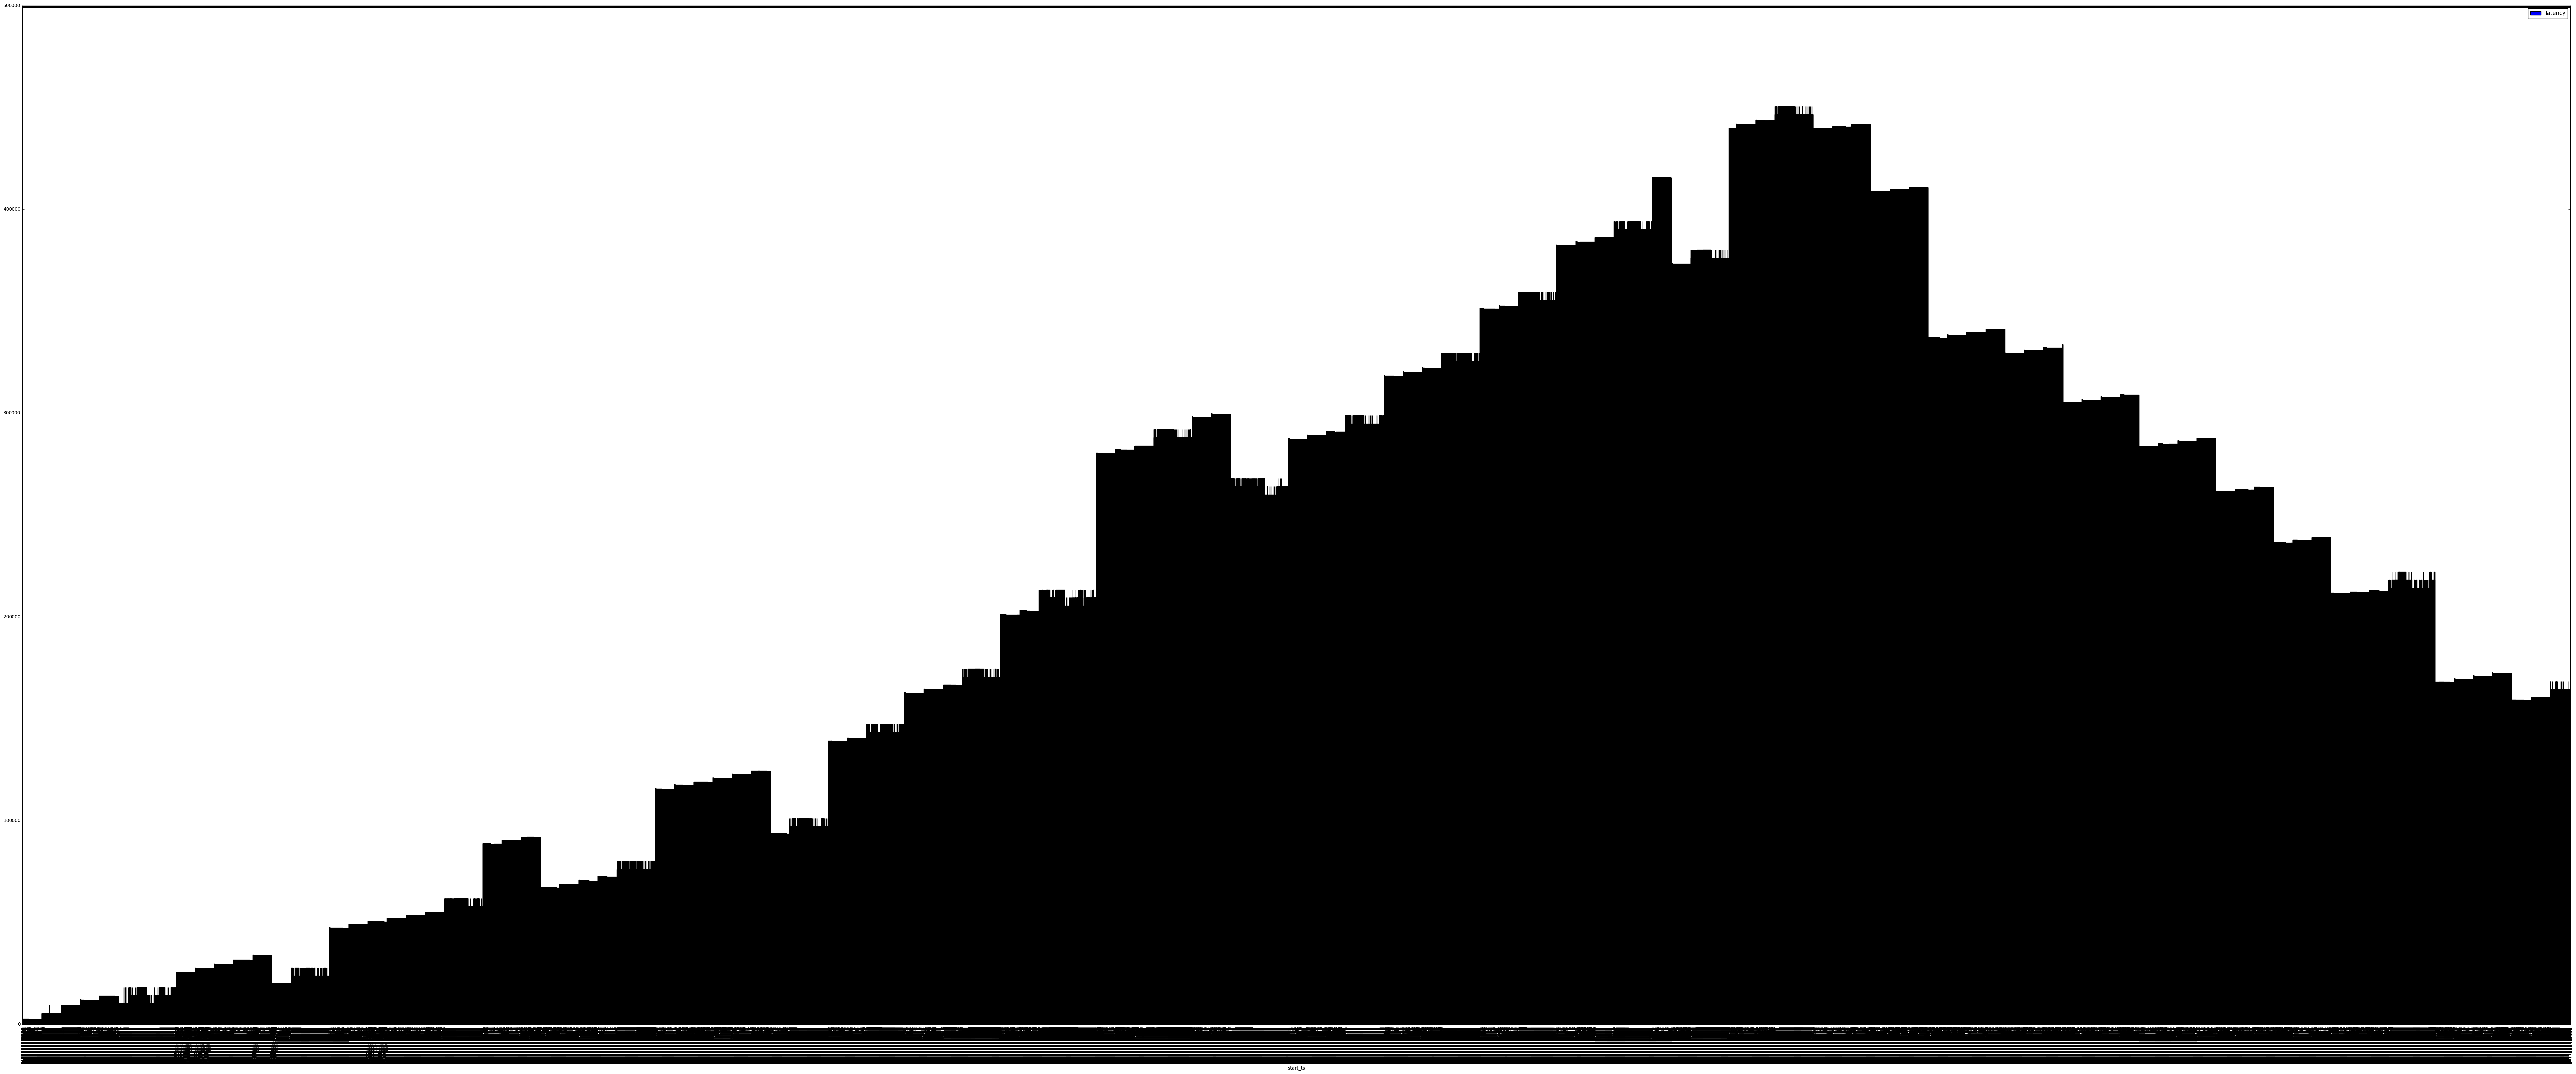

In [9]:
print('Flink')
print('Data generation rate into buffer: 210K ps')
print('Memory allocation- 8G per each node')
print('x axis indicates the generation time of tuple')
print('y axis indicates the latency of the tuple with given generation time')
print('This can be thought as the visualization of latencies as we progress')




temp_df  = buildDataFrame('/Users/jeka01/Desktop/temp/flink.csv')
df = pd.DataFrame({'latency':temp_df.latency, 'start_ts':temp_df.start_ts},
                      columns=['latency','start_ts'])
df.plot.bar(y='latency', x = 'start_ts',figsize=(100,40))

plt.show()


In [8]:

print('Spark')
print('Data generation rate into buffer: 210K ps')
print('Memory allocation- 8G per each node')
print('Job failed with memory issues')



Spark
Data generation rate into buffer: 210K ps
Memory allocation- 8G per each node
Job failed with memory issues


Spark
Data generation rate into buffer: 210K ps
Memory allocation- 16G per each node
x axis indicates the latency of tuples
y axis indicates the number of tuples with specified latency


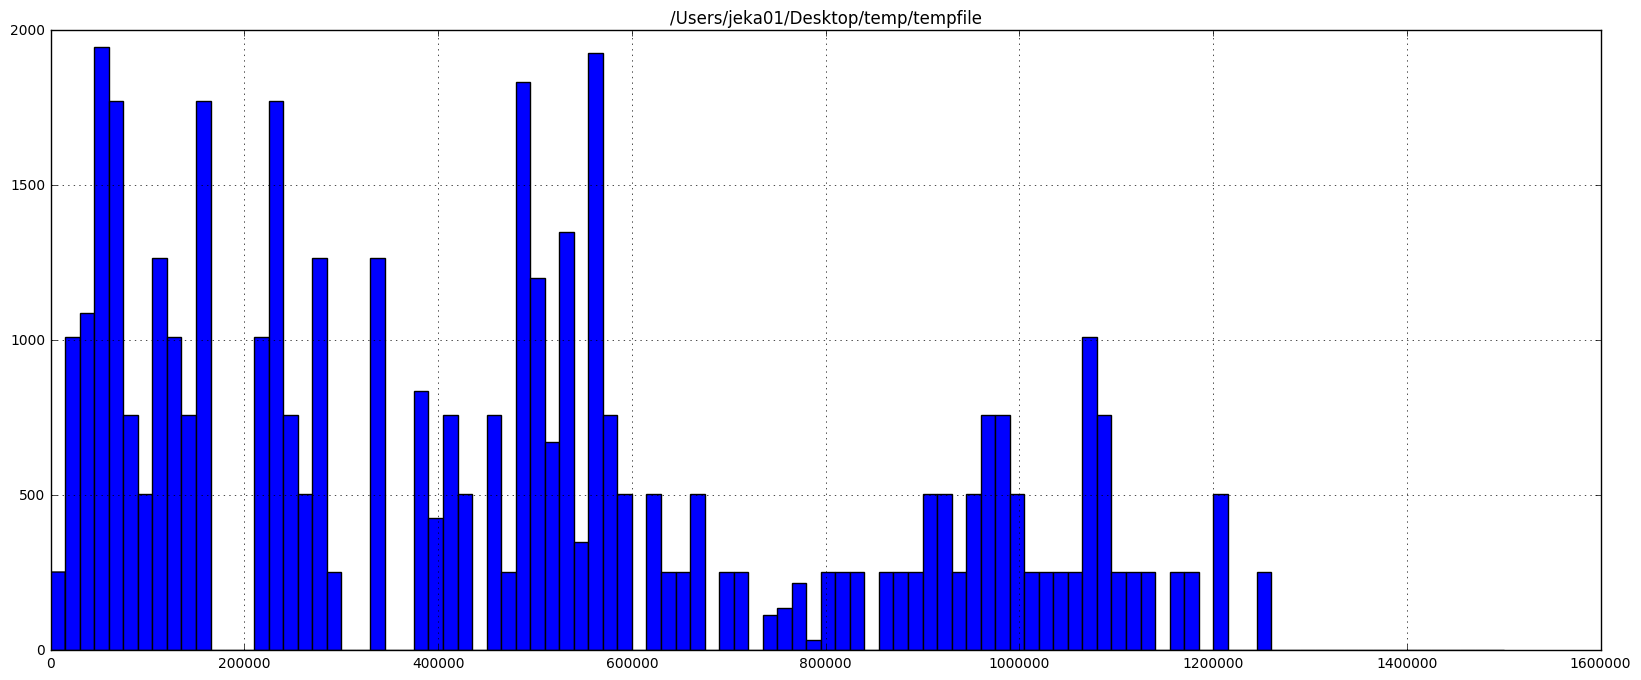

In [13]:
print('Spark')
print('Data generation rate into buffer: 210K ps')
print('Memory allocation- 16G per each node')
print('x axis indicates the latency of tuples')
print('y axis indicates the number of tuples with specified latency')




figsize = (20,8)
range = [0,1500000]

pandasDraw([['/Users/jeka01/Desktop/temp/tempfile.csv']],
            _figsize=figsize,_range=range)

plt.show()




Spark
Data generation rate into buffer: 210K ps
Memory allocation- 16G per each node
x axis indicates the generation time of tuple
y axis indicates the latency of the tuple with given generation time
This can be thought as the visualization of latencies as we progress


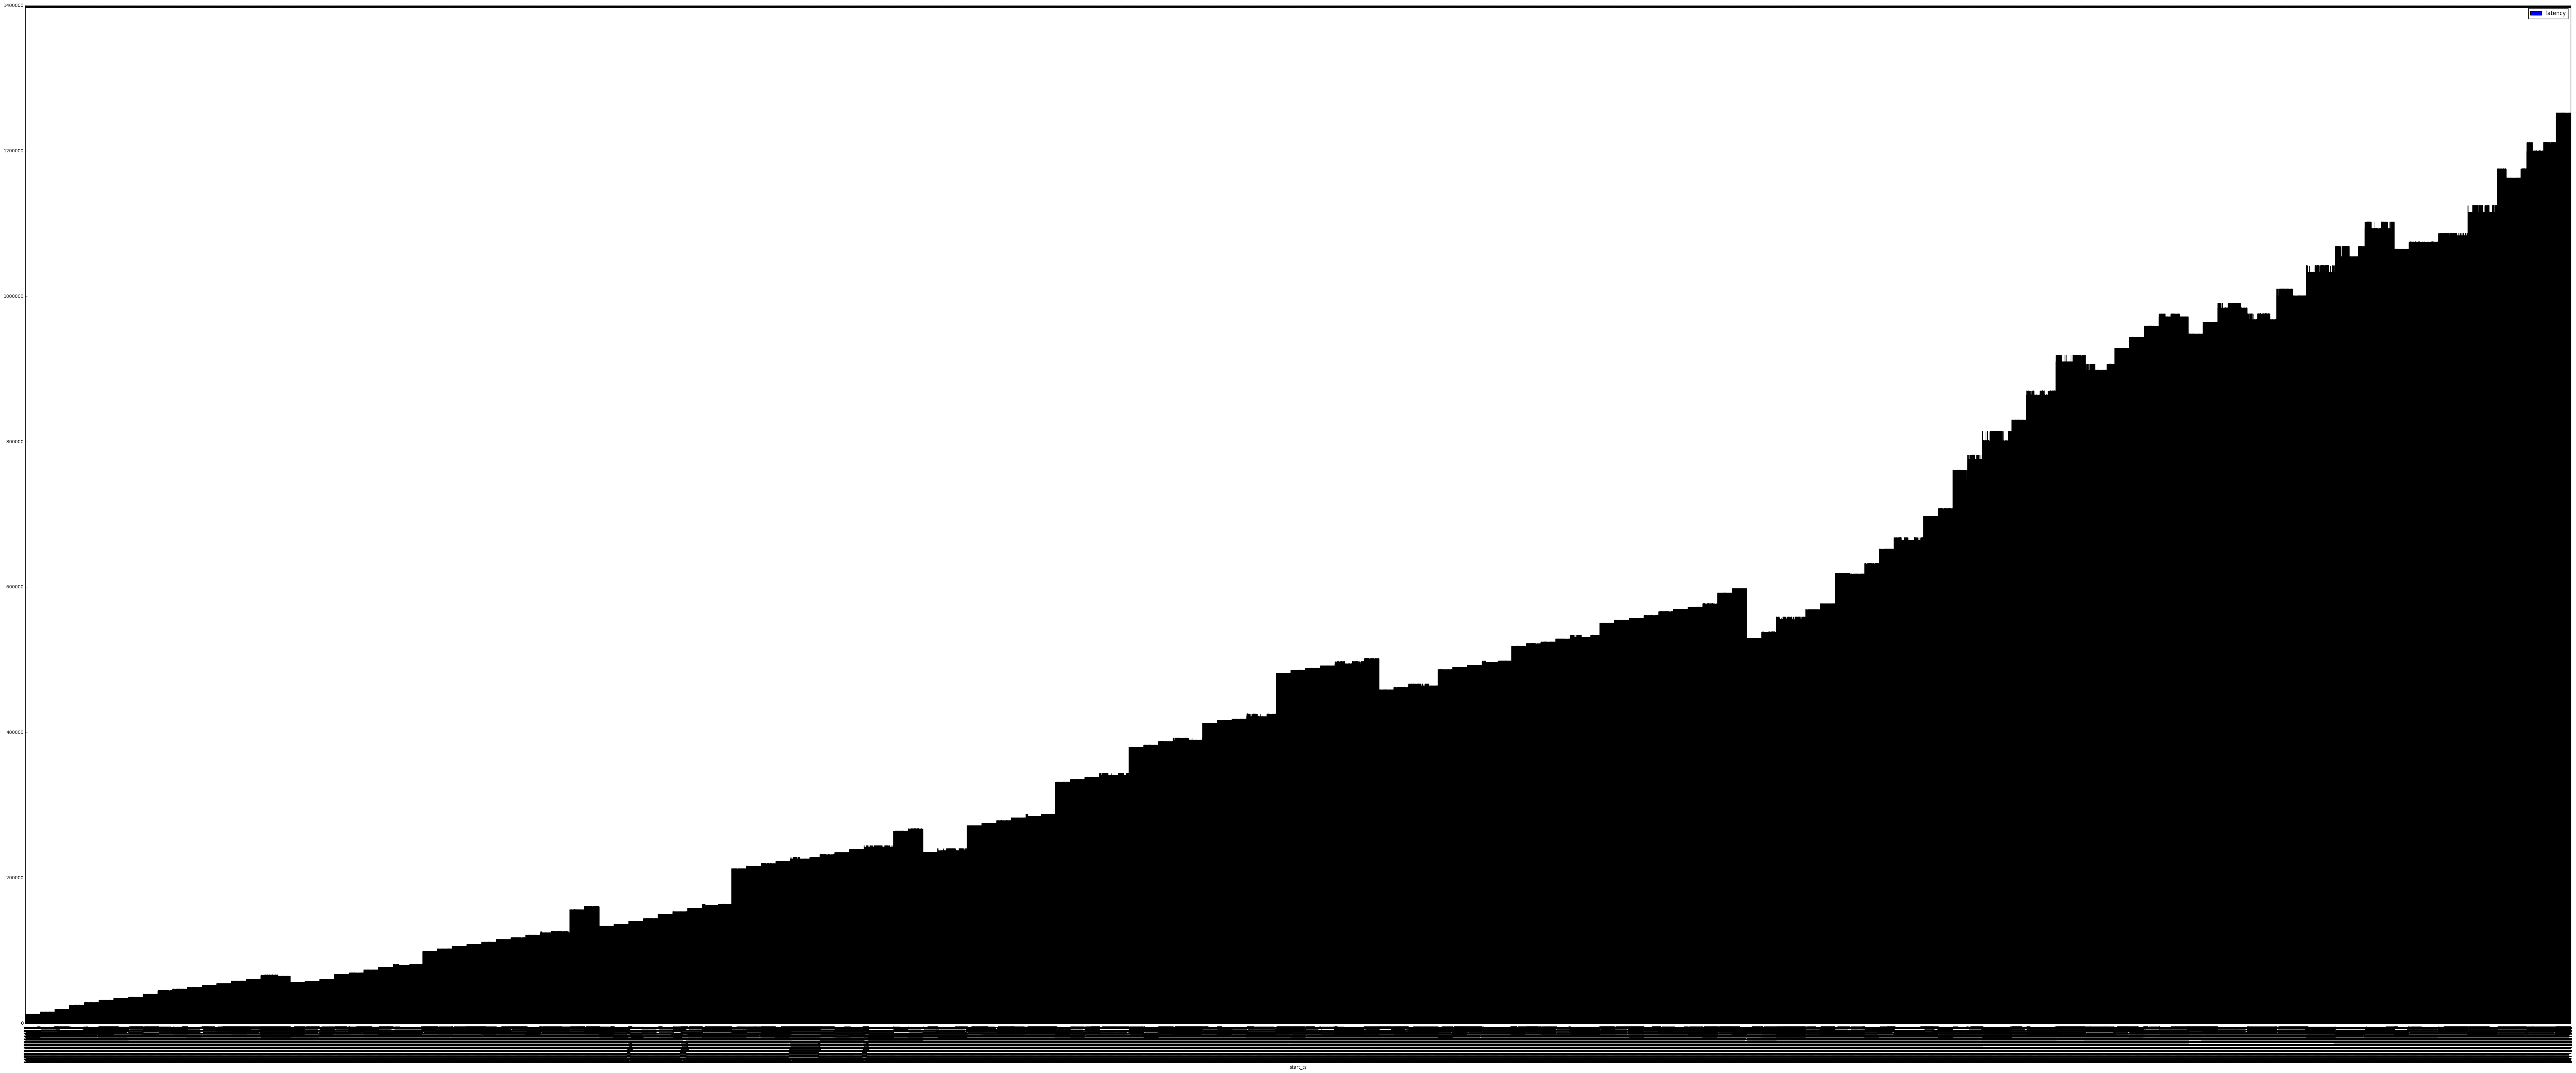

In [8]:
print('Spark')
print('Data generation rate into buffer: 210K ps')
print('Memory allocation- 16G per each node')
print('x axis indicates the generation time of tuple')
print('y axis indicates the latency of the tuple with given generation time')
print('This can be thought as the visualization of latencies as we progress')




temp_df  = buildDataFrame('/Users/jeka01/Desktop/temp/tempfile.csv')
df = pd.DataFrame({'latency':temp_df.latency, 'start_ts':temp_df.start_ts},
                      columns=['latency','start_ts'])
df.plot.bar(y='latency', x = 'start_ts',figsize=(100,40))

plt.show()

